# Panorama
written with two main components: sift and image stitching

## Part 0 : environment settings

In [ ]:
!pip install numpy
!pip install pandas
!pip install opencv-python
!pip install matplotlib

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
from IPython.core.debugger import Tracer
from functools import cmp_to_key

In [2]:
class KeyPoint:
    def __init__(self):
        self.pt=(0,0)
        self.pt_octavescale=(0,0)
        self.octave = -1
        self.layer = -1
        self.response = 0
        self.angle = 0
        self.feature = np.zeros(128)

## Part1 : SIFT

In [3]:
def BaseImg(img, sigma, blur):
    img = cv2.resize(img, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    sigma_diff = np.sqrt(max((sigma ** 2) - ((2 * blur) ** 2), 0.01))
    return cv2.GaussianBlur(img, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff)

### GetOctaveNum
solve equation of y/(2^x) = 1, at least 1 pixel is needed for a picture y is the smallest side of img.
log(y) = x*log(2), x = log(y)/log(2)

In [4]:
def GetOctaveNum(img_shape):
    return int(np.floor(np.log(np.min(img_shape))/np.log(2)))

### GetKernels
<b>Input:</b>
<br>sigma : Gaussian variance
<br>layer_num : the number of DoG layers per octave
<br><b>Output:</b>
<br>Gaussian Kernels
<br>Difference of Gaussian Kernels
<br><b>Parameters:</b>
<br>K : the scale of Gaussian blur from layer to layer, equals to 2^(1/layer_num)
<br>please reference to the origin implementation of Opencv for the sigma calculatio part
<br>https://gist.github.com/lxc-xx/7088609
<br>main idea is to cover the change between octives in the calculation of sigma_now = (sigma_total^2 - sigma_prev^2)^(1/2)

In [5]:
def GetKernels(sigma, layer_num, octave_num):
    K = 2**(1/layer_num)
    gaussian_layer_num = layer_num + 3
    dog_layer_num = layer_num + 2 
    sigmas = np.zeros(gaussian_layer_num)
    sigmas[0] = sigma
    for idx in range(1,gaussian_layer_num):
        sigma_prev = sigma*(K**(idx-1))
        sigma_total = K*sigma_prev
        sigmas[idx] = np.sqrt(sigma_total**2-sigma_prev**2)
    return sigmas

### GetPyrimid
by applying the precalculated sigmas to the images,

In [6]:
def GetPyrimid(img, octave_num, sigmas):
    pyrimid = []
    for idx in range(octave_num):
        layer_in_octave = []
        layer_in_octave.append(img)
        for sigma in sigmas[1:]:
            gau_img = cv2.GaussianBlur(img,(0,0),sigmaX=sigma,sigmaY=sigma)
            layer_in_octave.append(gau_img)
        pyrimid.append(layer_in_octave)
        img = layer_in_octave[-3]
        img = cv2.resize(img,(int(img.shape[1]/2),int(img.shape[0]/2)),interpolation=cv2.INTER_NEAREST)
    return pyrimid

### GetDogPyrimid
by subtracting the Gaussian images

In [7]:
def GetDogPyrimid(pyrimid):
    dog_pyrimid = []
    for octave in pyrimid:
        layer_in_octave = []
        for idx in range(len(octave)-1):
            #layer_in_octave.append(np.subtract(octave[idx+1],octave[idx]))
            layer_in_octave.append(octave[idx+1].astype(int)-octave[idx].astype(int))
        dog_pyrimid.append(layer_in_octave)
    return dog_pyrimid

### Find keypoints

In [8]:
def FindExtrema(img,dog_pyrimid,layer_num,threshold=1.275):
    keypoints = []
    for octave_idx,octave in enumerate(dog_pyrimid):
        for idx in range(1,len(octave)-1):
            for x in range(1,octave[idx].shape[0]-1):
                for y in range(1,octave[idx].shape[1]-1):
                    img_1 = octave[idx-1]
                    img_2 = octave[idx]
                    img_3 = octave[idx+1]
                    pixel_cube = np.array([img_1[x-1:x+2,y-1:y+2],img_2[x-1:x+2,y-1:y+2],img_3[x-1:x+2,y-1:y+2]],dtype=np.float)
                    #print(pixel_cube.shape)
                    if VerifyExtrema(pixel_cube,threshold):
                    #if VerifyExtrema(octave[idx-1:idx+2,x-1:x+2,y-1:y+2],threshold):
                        # localization here
                        '''
                        print("pixel_cube = {}".format(pixel_cube))
                        print("x = {}".format(x))
                        print("y = {}".format(y))
                        print("idx = {}".format(idx))
                        print("octave_idx = {}".format(octave_idx))
                        print("octave = {}".format(octave))
                        print("layer_num = {}".format(layer_num))
                        '''
                        localized_keypoint,keypoint_img = Localize(pixel_cube,x,y,idx,octave_idx,octave,layer_num)
                        if localized_keypoint != None:
                            keypoints.append(localized_keypoint)
    return keypoints
    #Visualize_keypoints(img,keypoints)
    
def VerifyExtrema(cube,threshold):
    cube = cube[0:3]
    if np.abs(cube[1,1,1])>threshold:
        if cube[1,1,1]>0:
            for x in range(0,3):
                for y in range(0,3):
                    for z in range(0,3):
                        if (x,y,z) == (1,1,1):
                            continue
                        if cube[1,1,1] <= cube[x,y,z]:
                            return False
            return True            
        elif cube[1,1,1]<0:
            for x in range(0,3):
                for y in range(0,3):
                    for z in range(0,3):
                        if (x,y,z) == (1,1,1):
                            continue
                        if cube[1,1,1] >= cube[x,y,z]:
                            return False
            return True

    return False                 
        

### Lacalization

In [9]:
def Localize(pixel_cube,x,y,idx,octave_idx,octave,layer_num,max_attempts=5,contrast_threshold=0.76):
    def out_of_range(x,y,idx):
        if x<0 or y<0 or idx<1:
            return True
        if x>octave[0].shape[0] or y>octave[0].shape[1] or idx>layer_num:
            return True
        return False
    
    for tries in range(max_attempts):
        '''
        img_1 = octave[idx-1]
        img_2 = octave[idx]
        img_3 = octave[idx+1]
        pixel_cube = [img_1[x-1:x+2,y-1:y+2],img_2[x-1:x+2,y-1:y+2],img_3[x-1:x+2,y-1:y+2]]
        pixel_cube = np.array(pixel_cube, dtype=np.float)
        '''
        gradient = ComputeGradient(pixel_cube)
        hess = ComputeHessian(pixel_cube)
        delta = -np.linalg.lstsq(hess,gradient,rcond=None)[0]
        if abs(delta[0])<0.5 and abs(delta[1])<0.5 and abs(delta[2])<0.5:
            break
        y += int(round(delta[0]))
        x += int(round(delta[1]))
        idx += int(round(delta[2]))
        if out_of_range(x,y,idx):
            break
        if tries == max_attempts-1:
            return None,None
    if out_of_range(x,y,idx):
        #print("out of picture size")
        return None,None
    
    ##### throw out low contrast #####
    D_hat = pixel_cube[1,1,1]+0.5*np.dot(gradient,delta)
    if np.abs(D_hat) > 0.03:
        hess_xy = hess[:2,:2]
        hess_Tr = np.trace(hess_xy)
        hess_Det = np.linalg.det(hess_xy)
        
        ##### eliminating edge responses #####
        r = 10
        if hess_Det !=0 and ((hess_Tr**2)/hess_Det)<(((r+1)**2)/r):
            # saving keypoint as a CV2 object
            keypoint = KeyPoint()
            keypoint.pt = ((y+delta[0])*(2**octave_idx),(x+delta[1])*(2**octave_idx))
            keypoint.pt_octavescale = ((y+delta[0]),(x+delta[1]))
            keypoint.octave = octave_idx
            keypoint.response = abs(D_hat)
            keypoint.layer = idx
            return keypoint,idx
    return None,None
        
    

In [10]:
def ComputeGradient(pixel_array):
    dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
    dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
    ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])
    return np.array([dx, dy, ds])

In [11]:
def ComputeHessian(pixel_array):
    center_pixel_value = pixel_array[1, 1, 1]
    dxx = pixel_array[1, 1, 2] - 2 * center_pixel_value + pixel_array[1, 1, 0]
    dyy = pixel_array[1, 2, 1] - 2 * center_pixel_value + pixel_array[1, 0, 1]
    dss = pixel_array[2, 1, 1] - 2 * center_pixel_value + pixel_array[0, 1, 1]
    dxy = 0.25 * (pixel_array[1, 2, 2] - pixel_array[1, 2, 0] - pixel_array[1, 0, 2] + pixel_array[1, 0, 0])
    dxs = 0.25 * (pixel_array[2, 1, 2] - pixel_array[2, 1, 0] - pixel_array[0, 1, 2] + pixel_array[0, 1, 0])
    dys = 0.25 * (pixel_array[2, 2, 1] - pixel_array[2, 0, 1] - pixel_array[0, 2, 1] + pixel_array[0, 0, 1])
    return np.array([[dxx, dxy, dxs], 
                  [dxy, dyy, dys],
                  [dxs, dys, dss]])

In [12]:
def Visualize_keypoints(img,keypoints):
    print(len(keypoints))
    implot = plt.imshow(img,cmap="gray")
    #for point in keypoints:
    x=[]
    y=[]
    for pt in keypoints:
        x.append(pt.pt[0])
        y.append(pt.pt[1])
    plt.plot(x,y,'y+')
    plt.show()
    


### Orientation assignment Juno

In [13]:
def Gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [14]:
def Accurate_Orientation(bucket, bucket_number, bucket_width=360/36): 
    center = bucket_number*bucket_width + bucket_width/2. 
    if bucket_number == len(bucket)-1: 
        rightval = 360 + bucket_width/2. 
    else: 
        rightval = (bucket_number+1)*bucket_width + bucket_width/2. 
    if bucket_number == 0: 
        leftval = -bucket_width/2. 
    else: leftval = (bucket_number-1)*bucket_width + bucket_width/2. 
    A = np.array([[center**2, center, 1], [rightval**2, rightval, 1], [leftval**2, leftval, 1]]) 
    b = np.array([ bucket[bucket_number], bucket[(bucket_number+1)%len(bucket)], bucket[(bucket_number-1)%len(bucket)]])
    x = np.linalg.lstsq(A, b, rcond=None)[0]
    if x[0] == 0: x[0] = 1e-6 
    return -x[1]/(2*x[0])

In [64]:
def Orientation_assignment(keypoints,gaussian_pyrimid,buckets=36):
    # calcualte the orientation for each keypoints
    keypoint_oriented = []
    for kp_idx,keypoint in enumerate(keypoints):
        (x,y) = keypoint.pt_octavescale
        if keypoint.octave == 0:
            keypoint_scale = 1
        else:
            keypoint_scale = 2**(1/keypoint.octave)
        scale_factor = 1.5
        sigma = scale_factor*keypoint_scale #not pretty sure about the scale
        filter_size = int(2*np.ceil(sigma)+1)
        gaussian_filter = Gauss2D((filter_size,filter_size),sigma)
        half_len = int(filter_size//2)
        # clculate the magnitude and theta within the area
        L = np.float32(gaussian_pyrimid[keypoint.octave][keypoint.layer])
        magnitude = np.zeros((filter_size,filter_size))
        theta = np.zeros((filter_size,filter_size))
        bucket = np.zeros(36)
        '''
        for i in range(int(y-half_len),int(y+half_len+1)):
            string = ""
            for j in range(int(x-half_len),int(x+half_len+1)):
                string = string + "\t" + str(L[i,j])
            print(string)
        '''
        for i in range(int(y-half_len),int(y+half_len+1)):
            for j in range(int(x-half_len),int(x+half_len+1)):
                print(i,j,L.shape)
                if i+1 >= L.shape[1] or j+1>=L.shape[0] or i-1 < 0 or j-1<0:
                    continue
                m = np.sqrt((L[j+1,i]-L[j-1,i])**2+(L[j,i+1]-L[j,i-1])**2)
                t = np.arctan2((L[j,i+1]-L[j,i-1]),(L[j+1,i]-L[j-1,i]))
                weighted_mag = m*gaussian_filter[i-int(y),j-int(x)]
                t = np.rad2deg(t)
                t=t%360
                buc_id = int(t//10)
                #print(buc_id)
                bucket[buc_id] = bucket[buc_id]+weighted_mag
        # visualize the histogram
        '''
        print(kp_idx)
        plt.plot(bucket)
        plt.show()
        '''
        # find the higest and second highest peak
        buc_dict = dict()
        for idx,val in enumerate(bucket):
            buc_dict[val] = idx
        #np.tolist(bucket).sort(reverse=True)
        sorted_bucket = np.copy(bucket)
        sorted_bucket = np.sort(sorted_bucket)
        #print(sorted_bucket)
        ori = buc_dict[sorted_bucket[-1]]
        keypoint.orientation = Accurate_Orientation(bucket, ori)
        keypoint_oriented.append(keypoint)
        #print(sorted_bucket[-2])
        #print(sorted_bucket[-1])
        if sorted_bucket[-2]>=0.8*sorted_bucket[-1]:
            new_kp = KeyPoint()
            new_kp.pt = keypoint.pt
            new_kp.pt_octavescale = keypoint.pt_octavescale
            new_kp.octave = keypoint.octave
            new_kp.layer = keypoint.layer
            new_kp.response = keypoint.response
            ori = buc_dict[sorted_bucket[-2]]
            keypoint.angle = Accurate_Orientation(bucket, ori)
            keypoint_oriented.append(new_kp)
    return keypoint_oriented

In [69]:
def GenerateDescriptors(keypoints,gaussian_pyrimid,width=16,sub_region=4):
    # generate the 128 featurevector for each keypoints
    half_window = 16/2
    descriptors = []
    for keypoint in keypoints:
        (x,y) = keypoint.pt_octavescale
        L = np.float32(gaussian_pyrimid[keypoint.octave][keypoint.layer])
        l = int(max(0,x-half_window))
        r = int(min(L.shape[1],x+half_window))
        t = int(max(0,y-half_window))
        b = int(min(L.shape[0],y+half_window))
        window = L[t:b,l:r]
        magnitude = np.zeros((16,16))
        orientation = np.zeros((16,16))
        # build orientation map and magnitude
        for i in range(t,b):
            mag = np.zeros(16)
            ori = np.zeros(16)
            for j in range(l,r):
                if i+1 >= b or j+1>=r or i-1 < 0 or j-1<0:
                    continue
                m = np.sqrt((L[i+1,j]-L[i-1,j])**2+(L[i,j+1]-L[i,j-1])**2)
                th = np.arctan2((L[i,j+1]-L[i,j-1]),(L[i+1,j]-L[i-1,j]))
                th = np.rad2deg(th)
                th=th%360
                magnitude[i-t,j-l] = m
                orientation[i-t,j-l] = th
        pad_top = int(abs((y-half_window)-t))
        pad_bot = int(abs((y+half_window)-b))
        pad_left = int(abs((x-half_window)-l))
        pad_right = int(abs((x+half_window)-r))
        np.pad(magnitude,((pad_top,pad_bot),(pad_left,pad_right)),"constant")
        np.pad(orientation,((pad_top,pad_bot),(pad_left,pad_right)),"constant")
        # generate gaussian filter
        gaussian_filter = Gauss2D((4,4),0.5*4)
        # calculate each subwindow
        feature_row = []
        for row in range(4):
            feature_col = []
            for col in range(4):
                sub_ori = orientation[row*4:row*4+4,col*4:col*4+4]
                sub_mag = magnitude[row*4:row*4+4,col*4:col*4+4]
                weighted_mag = np.multiply(sub_mag,gaussian_filter)
                hist = GetHist(weighted_mag,orientation)
                feature_col.append(hist)
            feature_row.append(feature_col)
        feature_row = np.array(feature_row,dtype=np.float32)
        feature_row.flatten()
        feature_row = feature_row/np.linalg.norm(feature_row)
        np.clip(feature_row,0,0.2)
        feature_row = feature_row/np.linalg.norm(feature_row)
        descriptors.append(feature_row)
    
    #descriptors = np.linalg.norm(descriptors)
    #descriptors = np.clip(descriptors,0,0.2)
    #descriptors = np.linalg.norm(descriptors)
    
    return np.array(descriptors,dtype=np.float32)
                
                
        

In [18]:
def GetHist(weighted_mag,orientation):
    bucket = np.zeros(8)
    for i in range(weighted_mag.shape[0]):
        for j in range(weighted_mag.shape[1]):
            print(orientation[i,j])
            bucket[int(orientation[i,j]//45)] = bucket[int(orientation[i,j]//45)]+weighted_mag[i,j]
    return bucket
        

## part2 : Image stitching

## Part3 : Main Function

In [19]:
sigma = 1.6
layer_num = 3
blur = 0.5
img_border_width = 5
array_of_img = [] # Store all the image data

In [ ]:
# Read directory function
def read_directory(directory_name):
    filenumber = len([name for name in os.listdir(directory_name) if os.path.isfile(os.path.join(directory_name, name))])
    for i in range(1,filenumber+1):
        img = cv2.imread(directory_name + "/" + str(i)+".jpg")
        array_of_img.append(img)

In [ ]:
def SIFT(inputname):
    read_directory(inputname)
    #use: len(array_of_img) for looping the image, array_of_img[0],
    #array_of_img[1],array_of_img[2],...for processing each image
    #Start SIFT here

    #End of SIFT here and use imageoutput for your output
    imageoutput = array_of_img[0]
    array_of_img.clear()
    return imageoutput

In [ ]:
f = open('testfile.txt', 'r')
dirname = str(f.readline()).strip()
while(dirname):   
    imageout=SIFT(dirname)
    plt.figure()
    plt.imshow(imageout)
    cv2.imwrite(dirname+'.jpg', imageout)
    dirname = str(f.readline()).strip()

## Part4 : Testing

In [20]:
#the input img must be a single grayscale image
def FindKeypoints(img, sigma=1.6, layer_num=3, blur=0.5):
    #base_img = BaseImg(img, sigma, blur)
    base_img = cv2.GaussianBlur(img,(0,0),sigmaX=sigma,sigmaY=sigma) 
    octave = GetOctaveNum(img.shape[:2])
    gaussian_kernels = GetKernels(sigma, layer_num, octave)
    gaussian_pyrimid = GetPyrimid(base_img,octave, gaussian_kernels)
    dog_pyrimid = GetDogPyrimid(gaussian_pyrimid)
    keypoints = FindExtrema(img,dog_pyrimid,layer_num)
    Visualize_keypoints(img,keypoints)
    #keypoints = removeDuplicateKeypoints(keypoints)
    #Visualize_keypoints(img,keypoints)
    #keypoints = convertKeypointsToInputImageSize(keypoints) 
    #Visualize_keypoints(img,keypoints)
    oriented_keypoints = Orientation_assignment(keypoints,gaussian_pyrimid)
    #descriptors = generateDescriptors(keypoints, gaussian_pyrimid)
    descriptors = GenerateDescriptors(oriented_keypoints,gaussian_pyrimid)
    return oriented_keypoints, descriptors

235


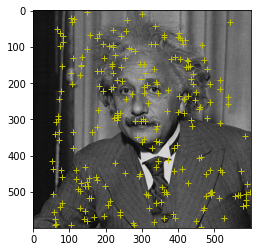

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


90.0
90.0
0.0
0.0
90.0
90.0
90.0
45.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
45.0
90.0
90.0
0.0
0.0
90.0
90.0
90.0
45.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
45.0
90.0
90.0
0.0
0.0
90.0
90.0
90.0
45.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
45.0
90.0
90.0
0.0
0.0
90.0
90.0
90.0
45.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
45.0
90.0
90.0
0.0
0.0
90.0
90.0
90.0
45.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
45.0
90.0
90.0
0.0
0.0
90.0
90.0
90.0
45.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
45.0
90.0
90.0
0.0
0.0
90.0
90.0
90.0
45.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
45.0
90.0
90.0
0.0
0.0
90.0
90.0
90.0
45.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
45.0
90.0
90.0
0.0
0.0
90.0
90.0
90.0
45.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
45.0
90.0
90.0
0.0
0.0
90.0
90.0
90.0
45.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
45.0
90.0
90.0
0.0
0.0
90.0
90.0
90.0
45.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
45.0
90.0
90.0
0.0
0.0
90.0
90.0
90.0
45.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
45.0
90.0
90.0
0.0
0.0
90.0
90.0
90.0
45.0
90.0
90.0
90.0
90.0
90.0
9

90.0
80.53767395019531
90.0
90.0
90.0
83.65980529785156
83.65980529785156
90.0
90.0
84.28939819335938
90.0
90.0
90.0
63.4349479675293
90.0
90.0
90.0
80.53767395019531
90.0
90.0
90.0
83.65980529785156
83.65980529785156
90.0
90.0
84.28939819335938
90.0
90.0
90.0
63.4349479675293
90.0
90.0
90.0
80.53767395019531
90.0
90.0
90.0
83.65980529785156
83.65980529785156
90.0
90.0
84.28939819335938
90.0
90.0
90.0
63.4349479675293
90.0
90.0
90.0
80.53767395019531
90.0
90.0
90.0
83.65980529785156
83.65980529785156
90.0
90.0
84.28939819335938
90.0
90.0
90.0
63.4349479675293
90.0
90.0
90.0
80.53767395019531
90.0
90.0
90.0
83.65980529785156
83.65980529785156
90.0
90.0
84.28939819335938
180.0
225.0
270.0
270.0
180.0
135.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
180.0
225.0
270.0
270.0
180.0
135.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
180.0
225.0
270.0
270.0
180.0
135.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
180.0
225.0
270.0
270.0
180.0
135.0
90.0
90.0
90.0
90.0
90.0
90.

0.0
315.0
0.0
315.0
0.0
333.43494987487793
315.0
315.0
315.0
315.0
315.0
0.0
315.0
333.43494987487793
0.0
0.0
0.0
315.0
0.0
315.0
0.0
333.43494987487793
315.0
315.0
315.0
315.0
315.0
0.0
315.0
333.43494987487793
0.0
0.0
0.0
315.0
0.0
315.0
0.0
333.43494987487793
315.0
315.0
315.0
315.0
315.0
0.0
315.0
333.43494987487793
0.0
0.0
0.0
315.0
0.0
315.0
0.0
333.43494987487793
315.0
315.0
315.0
315.0
315.0
0.0
315.0
333.43494987487793
0.0
0.0
0.0
315.0
0.0
315.0
0.0
333.43494987487793
315.0
315.0
315.0
315.0
315.0
0.0
315.0
333.43494987487793
0.0
0.0
0.0
225.0
270.0
270.0
270.0
180.0
225.0
225.0
315.0
180.0
225.0
0.0
0.0
180.0
180.0
0.0
0.0
225.0
270.0
270.0
270.0
180.0
225.0
225.0
315.0
180.0
225.0
0.0
0.0
180.0
180.0
0.0
0.0
225.0
270.0
270.0
270.0
180.0
225.0
225.0
315.0
180.0
225.0
0.0
0.0
180.0
180.0
0.0
0.0
225.0
270.0
270.0
270.0
180.0
225.0
225.0
315.0
180.0
225.0
0.0
0.0
180.0
180.0
0.0
0.0
225.0
270.0
270.0
270.0
180.0
225.0
225.0
315.0
180.0
225.0
0.0
0.0
180.0
180.0
0.0
0.0
225.0


347.4711923599243
348.6900682449341
347.4711923599243
330.25511932373047
330.9453983306885
333.43494987487793
323.1301040649414
310.6012992858887
326.30993270874023
322.1250190734863
307.8749885559082
299.0546073913574
6.34019136428833
5.710592746734619
5.710592746734619
0.0
347.4711923599243
348.6900682449341
347.4711923599243
330.25511932373047
330.9453983306885
333.43494987487793
323.1301040649414
310.6012992858887
326.30993270874023
322.1250190734863
307.8749885559082
299.0546073913574
6.34019136428833
5.710592746734619
5.710592746734619
0.0
347.4711923599243
348.6900682449341
347.4711923599243
330.25511932373047
330.9453983306885
333.43494987487793
323.1301040649414
310.6012992858887
326.30993270874023
322.1250190734863
307.8749885559082
299.0546073913574
6.34019136428833
5.710592746734619
5.710592746734619
0.0
347.4711923599243
348.6900682449341
347.4711923599243
330.25511932373047
330.9453983306885
333.43494987487793
323.1301040649414
310.6012992858887
326.30993270874023
322.125

230.71058654785156
225.0
236.3099365234375
235.0079803466797
225.0
220.23635864257812
236.3099365234375
228.36647033691406
221.98721313476562
213.69007873535156
188.13011169433594
187.12503051757812
180.0
188.13011169433594
215.53768920898438
206.56504821777344
200.55606079101562
203.1986083984375
236.3099365234375
229.39869689941406
220.60130310058594
215.53768920898438
248.19860076904297
240.9454116821289
233.1301040649414
225.0
188.13011169433594
187.12503051757812
180.0
188.13011169433594
215.53768920898438
206.56504821777344
200.55606079101562
203.1986083984375
236.3099365234375
229.39869689941406
220.60130310058594
215.53768920898438
248.19860076904297
240.9454116821289
233.1301040649414
225.0
188.13011169433594
187.12503051757812
180.0
188.13011169433594
215.53768920898438
206.56504821777344
200.55606079101562
203.1986083984375
236.3099365234375
229.39869689941406
220.60130310058594
215.53768920898438
248.19860076904297
240.9454116821289
233.1301040649414
225.0
188.1301116943359

225.0
0.0
270.0
270.0
225.0
225.0
225.0
270.0
243.4349594116211
270.0
225.0
225.0
243.4349594116211
180.0
225.0
225.0
225.0
164.05459594726562
167.47119140625
163.30075073242188
161.56504821777344
150.25511169433594
153.43495178222656
156.03750610351562
158.19857788085938
135.0
142.12501525878906
149.03623962402344
149.03623962402344
123.6900634765625
135.0
135.0
140.71058654785156
164.05459594726562
167.47119140625
163.30075073242188
161.56504821777344
150.25511169433594
153.43495178222656
156.03750610351562
158.19857788085938
135.0
142.12501525878906
149.03623962402344
149.03623962402344
123.6900634765625
135.0
135.0
140.71058654785156
164.05459594726562
167.47119140625
163.30075073242188
161.56504821777344
150.25511169433594
153.43495178222656
156.03750610351562
158.19857788085938
135.0
142.12501525878906
149.03623962402344
149.03623962402344
123.6900634765625
135.0
135.0
140.71058654785156
164.05459594726562
167.47119140625
163.30075073242188
161.56504821777344
150.25511169433594
1

278.1301040649414
279.4623260498047
270.0
270.0
281.3099365234375
279.4623260498047
270.0
270.0
270.0
281.3099365234375
281.3099365234375
270.0
281.3099365234375
284.03624725341797
281.3099365234375
284.03624725341797
278.1301040649414
279.4623260498047
270.0
270.0
281.3099365234375
279.4623260498047
270.0
270.0
270.0
281.3099365234375
281.3099365234375
270.0
281.3099365234375
284.03624725341797
281.3099365234375
284.03624725341797
278.1301040649414
279.4623260498047
270.0
270.0
281.3099365234375
279.4623260498047
270.0
270.0
270.0
281.3099365234375
281.3099365234375
270.0
281.3099365234375
284.03624725341797
281.3099365234375
284.03624725341797
278.1301040649414
279.4623260498047
270.0
270.0
281.3099365234375
279.4623260498047
270.0
270.0
270.0
281.3099365234375
281.3099365234375
270.0
281.3099365234375
284.03624725341797
281.3099365234375
284.03624725341797
270.0
270.0
243.4349594116211
236.3099365234375
270.0
251.56505584716797
243.4349594116211
255.9637680053711
270.0
258.690078735

90.0
104.0362319946289
104.0362319946289
108.43494415283203
90.0
108.43494415283203
123.6900634765625
116.5650405883789
90.0
116.5650405883789
135.0
116.5650405883789
90.0
116.5650405883789
135.0
135.0
90.0
104.0362319946289
104.0362319946289
108.43494415283203
90.0
108.43494415283203
123.6900634765625
116.5650405883789
90.0
116.5650405883789
135.0
116.5650405883789
90.0
116.5650405883789
135.0
135.0
90.0
104.0362319946289
104.0362319946289
108.43494415283203
90.0
108.43494415283203
123.6900634765625
116.5650405883789
90.0
116.5650405883789
135.0
116.5650405883789
90.0
116.5650405883789
135.0
135.0
90.0
104.0362319946289
104.0362319946289
108.43494415283203
90.0
108.43494415283203
123.6900634765625
116.5650405883789
90.0
116.5650405883789
135.0
116.5650405883789
90.0
116.5650405883789
135.0
135.0
90.0
104.0362319946289
104.0362319946289
108.43494415283203
90.0
108.43494415283203
123.6900634765625
116.5650405883789
90.0
116.5650405883789
135.0
116.5650405883789
90.0
116.5650405883789
13

90.0
135.0
135.0
315.0
135.0
135.0
135.0
135.0
135.0
135.0
180.0
135.0
153.43495178222656
180.0
135.0
180.0
90.0
135.0
135.0
315.0
135.0
135.0
135.0
135.0
135.0
135.0
180.0
135.0
153.43495178222656
180.0
135.0
180.0
90.0
135.0
135.0
315.0
135.0
135.0
135.0
135.0
135.0
135.0
180.0
135.0
153.43495178222656
180.0
135.0
180.0
90.0
135.0
135.0
315.0
135.0
135.0
135.0
135.0
135.0
135.0
180.0
135.0
153.43495178222656
180.0
135.0
180.0
90.0
135.0
135.0
315.0
135.0
135.0
135.0
135.0
135.0
135.0
180.0
135.0
153.43495178222656
180.0
135.0
180.0
90.0
135.0
135.0
315.0
135.0
135.0
135.0
135.0
135.0
135.0
180.0
135.0
153.43495178222656
180.0
135.0
180.0
90.0
135.0
135.0
315.0
135.0
135.0
135.0
135.0
135.0
135.0
180.0
135.0
153.43495178222656
180.0
135.0
180.0
90.0
135.0
135.0
315.0
135.0
135.0
135.0
135.0
135.0
135.0
180.0
135.0
153.43495178222656
180.0
135.0
180.0
90.0
135.0
135.0
315.0
135.0
135.0
135.0
135.0
135.0
135.0
180.0
135.0
153.43495178222656
180.0
135.0
180.0
90.0
135.0
135.0
315.0
135.0

0.0
315.0
333.43494987487793
135.0
90.0
45.0
26.56505012512207
90.0
90.0
71.56504821777344
56.309932708740234
90.0
71.56504821777344
63.4349479675293
71.56504821777344
0.0
0.0
315.0
333.43494987487793
135.0
90.0
45.0
26.56505012512207
90.0
90.0
71.56504821777344
56.309932708740234
90.0
71.56504821777344
63.4349479675293
71.56504821777344
0.0
0.0
315.0
333.43494987487793
135.0
90.0
45.0
26.56505012512207
90.0
90.0
71.56504821777344
56.309932708740234
90.0
71.56504821777344
63.4349479675293
71.56504821777344
0.0
0.0
315.0
333.43494987487793
135.0
90.0
45.0
26.56505012512207
90.0
90.0
71.56504821777344
56.309932708740234
90.0
71.56504821777344
63.4349479675293
71.56504821777344
0.0
0.0
315.0
333.43494987487793
135.0
90.0
45.0
26.56505012512207
90.0
90.0
71.56504821777344
56.309932708740234
90.0
71.56504821777344
63.4349479675293
71.56504821777344
0.0
0.0
315.0
333.43494987487793
135.0
90.0
45.0
26.56505012512207
90.0
90.0
71.56504821777344
56.309932708740234
90.0
71.56504821777344
63.4349

315.0
315.0
0.0
0.0
0.0
0.0
0.0
315.0
0.0
0.0
315.0
315.0
315.0
0.0
270.0
0.0
315.0
315.0
0.0
0.0
0.0
0.0
0.0
315.0
0.0
0.0
315.0
315.0
315.0
0.0
270.0
0.0
315.0
315.0
0.0
0.0
0.0
0.0
0.0
315.0
0.0
0.0
315.0
315.0
315.0
0.0
270.0
0.0
315.0
315.0
0.0
0.0
0.0
0.0
0.0
315.0
0.0
0.0
315.0
315.0
315.0
0.0
270.0
0.0
315.0
315.0
0.0
0.0
0.0
0.0
0.0
315.0
0.0
0.0
315.0
315.0
315.0
0.0
270.0
0.0
315.0
315.0
0.0
0.0
0.0
0.0
0.0
315.0
0.0
0.0
315.0
315.0
315.0
0.0
270.0
0.0
315.0
315.0
0.0
0.0
0.0
0.0
0.0
315.0
0.0
0.0
315.0
315.0
315.0
0.0
270.0
0.0
315.0
315.0
0.0
0.0
0.0
0.0
0.0
315.0
0.0
0.0
315.0
315.0
315.0
0.0
270.0
0.0
315.0
315.0
0.0
0.0
0.0
0.0
0.0
315.0
0.0
0.0
315.0
315.0
315.0
0.0
270.0
0.0
315.0
315.0
0.0
0.0
0.0
0.0
0.0
315.0
0.0
0.0
315.0
315.0
315.0
0.0
270.0
0.0
315.0
315.0
0.0
0.0
0.0
0.0
0.0
315.0
0.0
0.0
315.0
315.0
315.0
0.0
270.0
0.0
315.0
315.0
0.0
0.0
0.0
0.0
0.0
315.0
0.0
0.0
315.0
315.0
315.0
0.0
270.0
0.0
315.0
315.0
0.0
0.0
0.0
0.0
0.0
315.0
0.0
0.0
315.0
315.0
315.0


95.19442749023438
90.0
90.0
79.69514465332031
123.6900634765625
116.5650405883789
63.4349479675293
45.0
251.56505584716797
260.53768157958984
270.0
278.1301040649414
93.366455078125
90.0
86.63353729248047
82.8749771118164
95.19442749023438
90.0
90.0
79.69514465332031
123.6900634765625
116.5650405883789
63.4349479675293
45.0
251.56505584716797
260.53768157958984
270.0
278.1301040649414
93.366455078125
90.0
86.63353729248047
82.8749771118164
95.19442749023438
90.0
90.0
79.69514465332031
123.6900634765625
116.5650405883789
63.4349479675293
45.0
251.56505584716797
260.53768157958984
270.0
278.1301040649414
93.366455078125
90.0
86.63353729248047
82.8749771118164
95.19442749023438
90.0
90.0
79.69514465332031
123.6900634765625
116.5650405883789
63.4349479675293
45.0
251.56505584716797
260.53768157958984
270.0
278.1301040649414
93.366455078125
90.0
86.63353729248047
82.8749771118164
95.19442749023438
90.0
90.0
79.69514465332031
123.6900634765625
116.5650405883789
63.4349479675293
45.0
251.5650

90.0
90.0
90.0
116.5650405883789
116.5650405883789
90.0
180.0
0.0
0.0
180.0
270.0
225.0
243.4349594116211
270.0
90.0
90.0
90.0
90.0
90.0
116.5650405883789
116.5650405883789
90.0
180.0
0.0
0.0
180.0
270.0
225.0
243.4349594116211
270.0
90.0
90.0
90.0
90.0
90.0
116.5650405883789
116.5650405883789
90.0
180.0
0.0
0.0
180.0
270.0
225.0
243.4349594116211
270.0
90.0
90.0
90.0
90.0
90.0
116.5650405883789
116.5650405883789
90.0
180.0
0.0
0.0
180.0
270.0
225.0
243.4349594116211
270.0
90.0
90.0
90.0
90.0
90.0
116.5650405883789
116.5650405883789
90.0
180.0
0.0
0.0
180.0
270.0
225.0
243.4349594116211
270.0
90.0
90.0
90.0
90.0
90.0
116.5650405883789
116.5650405883789
90.0
180.0
0.0
0.0
180.0
270.0
225.0
243.4349594116211
270.0
90.0
90.0
90.0
90.0
90.0
116.5650405883789
116.5650405883789
90.0
180.0
0.0
0.0
180.0
270.0
225.0
243.4349594116211
270.0
90.0
90.0
90.0
90.0
90.0
116.5650405883789
116.5650405883789
90.0
180.0
0.0
0.0
180.0
270.0
225.0
243.4349594116211
270.0
0.0
0.0
0.0
315.0
0.0
315.0
0.0
27

270.0
270.0
270.0
288.43495178222656
288.43495178222656
270.0
270.0
270.0
288.43495178222656
288.43495178222656
270.0
288.43495178222656
296.5650520324707
288.43495178222656
296.5650520324707
270.0
270.0
270.0
270.0
288.43495178222656
288.43495178222656
270.0
270.0
270.0
288.43495178222656
288.43495178222656
270.0
288.43495178222656
296.5650520324707
288.43495178222656
296.5650520324707
270.0
270.0
270.0
270.0
288.43495178222656
288.43495178222656
270.0
270.0
270.0
288.43495178222656
288.43495178222656
270.0
288.43495178222656
296.5650520324707
288.43495178222656
296.5650520324707
270.0
270.0
270.0
270.0
288.43495178222656
288.43495178222656
270.0
270.0
270.0
288.43495178222656
288.43495178222656
270.0
288.43495178222656
296.5650520324707
288.43495178222656
296.5650520324707
270.0
270.0
270.0
270.0
288.43495178222656
288.43495178222656
270.0
270.0
270.0
288.43495178222656
288.43495178222656
270.0
288.43495178222656
296.5650520324707
288.43495178222656
296.5650520324707
270.0
270.0
270.

315.0
315.0
270.0
270.0
270.0
270.0
270.0
270.0
270.0
315.0
90.0
90.0
90.0
90.0
270.0
270.0
315.0
315.0
270.0
270.0
270.0
270.0
270.0
270.0
270.0
315.0
90.0
90.0
90.0
90.0
270.0
270.0
315.0
315.0
270.0
270.0
270.0
270.0
270.0
270.0
270.0
315.0
90.0
90.0
90.0
90.0
270.0
270.0
315.0
315.0
270.0
270.0
270.0
270.0
270.0
270.0
270.0
315.0
90.0
90.0
90.0
90.0
270.0
270.0
315.0
315.0
270.0
270.0
270.0
270.0
270.0
270.0
270.0
315.0
90.0
90.0
90.0
90.0
270.0
270.0
315.0
315.0
270.0
270.0
270.0
270.0
270.0
270.0
270.0
315.0
90.0
90.0
90.0
90.0
270.0
270.0
315.0
315.0
270.0
270.0
270.0
270.0
270.0
270.0
270.0
315.0
90.0
90.0
90.0
90.0
270.0
270.0
315.0
315.0
270.0
270.0
270.0
270.0
270.0
270.0
270.0
315.0
90.0
90.0
90.0
90.0
270.0
270.0
315.0
315.0
270.0
270.0
270.0
270.0
270.0
270.0
270.0
315.0
90.0
90.0
90.0
90.0
270.0
270.0
315.0
315.0
270.0
270.0
270.0
270.0
270.0
270.0
270.0
315.0
90.0
90.0
90.0
90.0
270.0
270.0
315.0
315.0
270.0
270.0
270.0
270.0
270.0
270.0
270.0
315.0
90.0
90.0
90.0
90.0


108.43494415283203
104.0362319946289
116.5650405883789
135.0
90.0
0.0
116.5650405883789
116.5650405883789
116.5650405883789
135.0
123.6900634765625
108.43494415283203
116.5650405883789
108.43494415283203
123.6900634765625
116.5650405883789
108.43494415283203
104.0362319946289
116.5650405883789
135.0
90.0
0.0
116.5650405883789
116.5650405883789
116.5650405883789
135.0
123.6900634765625
108.43494415283203
116.5650405883789
108.43494415283203
123.6900634765625
116.5650405883789
108.43494415283203
104.0362319946289
116.5650405883789
135.0
90.0
0.0
116.5650405883789
116.5650405883789
116.5650405883789
135.0
123.6900634765625
108.43494415283203
116.5650405883789
108.43494415283203
123.6900634765625
116.5650405883789
108.43494415283203
104.0362319946289
307.30395126342773
305.2724266052246
306.1193428039551
304.8753318786621
306.43085861206055
305.7889747619629
304.62416076660156
304.6951560974121
306.1193428039551
304.62416076660156
305.7889747619629
306.43085861206055
304.9920234680176
304.

78.6900634765625
90.0
101.30992126464844
108.43494415283203
68.1985855102539
90.0
101.30992126464844
99.46231842041016
80.53767395019531
90.0
90.0
99.46231842041016
68.1985855102539
90.0
90.0
99.46231842041016
78.6900634765625
90.0
101.30992126464844
108.43494415283203
68.1985855102539
90.0
101.30992126464844
99.46231842041016
80.53767395019531
90.0
90.0
99.46231842041016
68.1985855102539
90.0
90.0
99.46231842041016
78.6900634765625
90.0
101.30992126464844
108.43494415283203
68.1985855102539
90.0
101.30992126464844
99.46231842041016
80.53767395019531
90.0
90.0
99.46231842041016
68.1985855102539
90.0
90.0
99.46231842041016
78.6900634765625
90.0
101.30992126464844
108.43494415283203
68.1985855102539
90.0
101.30992126464844
99.46231842041016
80.53767395019531
90.0
90.0
99.46231842041016
68.1985855102539
90.0
90.0
99.46231842041016
78.6900634765625
90.0
101.30992126464844
108.43494415283203
68.1985855102539
90.0
101.30992126464844
99.46231842041016
80.53767395019531
90.0
90.0
99.4623184204

0.0
0.0
135.0
135.0
0.0
0.0
0.0
135.0
0.0
180.0
225.0
270.0
0.0
180.0
135.0
0.0
0.0
0.0
135.0
135.0
0.0
0.0
0.0
135.0
0.0
180.0
225.0
270.0
0.0
180.0
135.0
0.0
0.0
0.0
135.0
135.0
0.0
0.0
0.0
135.0
0.0
180.0
225.0
270.0
0.0
180.0
135.0
0.0
0.0
0.0
135.0
135.0
0.0
0.0
0.0
135.0
0.0
180.0
225.0
270.0
0.0
180.0
135.0
0.0
0.0
0.0
135.0
135.0
0.0
0.0
0.0
135.0
0.0
180.0
225.0
270.0
0.0
180.0
135.0
0.0
0.0
0.0
135.0
135.0
0.0
0.0
0.0
135.0
0.0
180.0
225.0
270.0
0.0
180.0
135.0
0.0
0.0
0.0
135.0
135.0
0.0
0.0
0.0
135.0
0.0
180.0
225.0
270.0
0.0
180.0
135.0
0.0
0.0
0.0
135.0
135.0
0.0
0.0
0.0
135.0
0.0
180.0
225.0
270.0
0.0
180.0
135.0
0.0
0.0
0.0
135.0
135.0
0.0
0.0
0.0
135.0
68.1985855102539
68.1985855102539
66.80140686035156
66.80140686035156
71.56504821777344
66.80140686035156
66.80140686035156
66.80140686035156
66.80140686035156
66.80140686035156
63.4349479675293
63.4349479675293
74.05460357666016
68.1985855102539
68.1985855102539
63.4349479675293
68.1985855102539
68.1985855102539
66.8014

90.0
90.0
45.0
45.0
90.0
90.0
90.0
45.0
90.0
90.0
90.0
90.0
63.4349479675293
90.0
90.0
90.0
90.0
90.0
45.0
45.0
90.0
90.0
90.0
45.0
90.0
90.0
90.0
90.0
63.4349479675293
90.0
90.0
90.0
90.0
90.0
45.0
45.0
90.0
90.0
90.0
45.0
90.0
90.0
90.0
90.0
63.4349479675293
90.0
90.0
90.0
90.0
90.0
45.0
45.0
90.0
90.0
90.0
45.0
90.0
90.0
90.0
90.0
63.4349479675293
90.0
90.0
90.0
90.0
90.0
45.0
45.0
90.0
90.0
90.0
45.0
90.0
90.0
90.0
90.0
63.4349479675293
90.0
90.0
90.0
90.0
90.0
45.0
45.0
90.0
90.0
90.0
45.0
90.0
90.0
90.0
90.0
63.4349479675293
90.0
90.0
90.0
90.0
90.0
45.0
45.0
90.0
90.0
90.0
45.0
90.0
90.0
90.0
90.0
63.4349479675293
90.0
90.0
90.0
90.0
90.0
45.0
45.0
90.0
90.0
90.0
45.0
90.0
90.0
90.0
90.0
63.4349479675293
90.0
90.0
90.0
90.0
90.0
45.0
45.0
90.0
90.0
90.0
45.0
90.0
90.0
90.0
90.0
63.4349479675293
90.0
90.0
90.0
90.0
90.0
45.0
45.0
90.0
90.0
90.0
45.0
90.0
90.0
90.0
90.0
63.4349479675293
90.0
90.0
90.0
90.0
90.0
45.0
45.0
90.0
90.0
90.0
45.0
90.0
90.0
90.0
90.0
63.4349479675293
90.

90.0
83.65980529785156
83.65980529785156
90.0
90.0
90.0
90.0
99.46231842041016
99.46231842041016
90.0
80.53767395019531
98.13009643554688
90.0
90.0
90.0
97.12501525878906
90.0
83.65980529785156
83.65980529785156
90.0
90.0
90.0
90.0
99.46231842041016
99.46231842041016
90.0
80.53767395019531
98.13009643554688
90.0
90.0
90.0
97.12501525878906
90.0
83.65980529785156
83.65980529785156
90.0
90.0
90.0
90.0
99.46231842041016
99.46231842041016
90.0
80.53767395019531
98.13009643554688
90.0
90.0
90.0
97.12501525878906
90.0
83.65980529785156
83.65980529785156
90.0
90.0
90.0
90.0
99.46231842041016
99.46231842041016
90.0
80.53767395019531
98.13009643554688
90.0
90.0
90.0
97.12501525878906
90.0
83.65980529785156
83.65980529785156
90.0
90.0
90.0
90.0
99.46231842041016
99.46231842041016
90.0
80.53767395019531
98.13009643554688
90.0
90.0
90.0
97.12501525878906
90.0
83.65980529785156
83.65980529785156
90.0
90.0
90.0
90.0
99.46231842041016
99.46231842041016
90.0
80.53767395019531
98.13009643554688
90.0
90

108.43494415283203
71.56504821777344
71.56504821777344
90.0
90.0
90.0
90.0
90.0
45.0
90.0
90.0
135.0
0.0
90.0
0.0
180.0
108.43494415283203
71.56504821777344
71.56504821777344
90.0
90.0
90.0
90.0
90.0
45.0
90.0
90.0
135.0
0.0
90.0
0.0
180.0
108.43494415283203
71.56504821777344
71.56504821777344
90.0
90.0
90.0
90.0
90.0
45.0
90.0
90.0
135.0
0.0
90.0
0.0
180.0
108.43494415283203
71.56504821777344
71.56504821777344
90.0
90.0
90.0
90.0
90.0
45.0
90.0
90.0
135.0
0.0
90.0
0.0
180.0
108.43494415283203
71.56504821777344
71.56504821777344
90.0
90.0
90.0
90.0
90.0
45.0
90.0
90.0
135.0
0.0
90.0
0.0
180.0
108.43494415283203
71.56504821777344
71.56504821777344
90.0
90.0
90.0
90.0
90.0
45.0
90.0
90.0
135.0
0.0
90.0
0.0
180.0
108.43494415283203
71.56504821777344
71.56504821777344
90.0
90.0
90.0
90.0
90.0
45.0
90.0
90.0
135.0
0.0
90.0
0.0
180.0
108.43494415283203
71.56504821777344
71.56504821777344
90.0
90.0
90.0
90.0
90.0
45.0
90.0
90.0
135.0
0.0
90.0
0.0
180.0
108.43494415283203
71.56504821777344
71.

90.0
90.0
45.0
63.4349479675293
90.0
116.5650405883789
45.0
63.4349479675293
90.0
135.0
63.4349479675293
71.56504821777344
90.0
90.0
63.4349479675293
63.4349479675293
90.0
90.0
45.0
63.4349479675293
90.0
116.5650405883789
45.0
63.4349479675293
90.0
135.0
63.4349479675293
71.56504821777344
90.0
90.0
63.4349479675293
63.4349479675293
90.0
90.0
45.0
63.4349479675293
90.0
116.5650405883789
45.0
63.4349479675293
90.0
135.0
63.4349479675293
71.56504821777344
90.0
90.0
63.4349479675293
63.4349479675293
90.0
90.0
45.0
63.4349479675293
90.0
116.5650405883789
45.0
63.4349479675293
90.0
135.0
63.4349479675293
71.56504821777344
90.0
90.0
63.4349479675293
63.4349479675293
90.0
90.0
45.0
63.4349479675293
90.0
116.5650405883789
45.0
63.4349479675293
90.0
135.0
63.4349479675293
71.56504821777344
90.0
90.0
63.4349479675293
63.4349479675293
90.0
90.0
45.0
63.4349479675293
90.0
116.5650405883789
45.0
63.4349479675293
90.0
135.0
63.4349479675293
71.56504821777344
90.0
90.0
63.4349479675293
63.434947967529

270.0
270.0
288.43495178222656
296.5650520324707
296.5650520324707
270.0
315.0
270.0
288.43495178222656
288.43495178222656
270.0
288.43495178222656
288.43495178222656
270.0
270.0
288.43495178222656
270.0
270.0
288.43495178222656
296.5650520324707
296.5650520324707
270.0
315.0
270.0
288.43495178222656
288.43495178222656
270.0
288.43495178222656
288.43495178222656
270.0
270.0
288.43495178222656
270.0
270.0
288.43495178222656
296.5650520324707
296.5650520324707
270.0
315.0
270.0
288.43495178222656
288.43495178222656
270.0
288.43495178222656
288.43495178222656
270.0
270.0
288.43495178222656
270.0
270.0
288.43495178222656
296.5650520324707
296.5650520324707
270.0
315.0
270.0
288.43495178222656
288.43495178222656
270.0
288.43495178222656
288.43495178222656
270.0
270.0
288.43495178222656
270.0
270.0
288.43495178222656
296.5650520324707
296.5650520324707
270.0
315.0
270.0
288.43495178222656
288.43495178222656
270.0
288.43495178222656
288.43495178222656
270.0
270.0
288.43495178222656
270.0
270.

158.19857788085938
180.0
315.0
303.69006729125977
158.19857788085938
146.30992126464844
270.0
315.0
180.0
333.43494987487793
333.43494987487793
326.30993270874023
161.56504821777344
315.0
326.30993270874023
315.0
158.19857788085938
180.0
315.0
303.69006729125977
158.19857788085938
146.30992126464844
270.0
315.0
180.0
333.43494987487793
333.43494987487793
326.30993270874023
161.56504821777344
315.0
326.30993270874023
315.0
158.19857788085938
180.0
315.0
303.69006729125977
158.19857788085938
146.30992126464844
270.0
315.0
180.0
333.43494987487793
333.43494987487793
326.30993270874023
161.56504821777344
315.0
326.30993270874023
315.0
158.19857788085938
180.0
315.0
303.69006729125977
158.19857788085938
146.30992126464844
270.0
315.0
180.0
333.43494987487793
333.43494987487793
326.30993270874023
161.56504821777344
315.0
326.30993270874023
315.0
158.19857788085938
180.0
315.0
303.69006729125977
158.19857788085938
146.30992126464844
270.0
315.0
180.0
333.43494987487793
333.43494987487793
326.

229.39869689941406
229.39869689941406
253.30076599121094
243.4349594116211
239.03624725341797
239.03624725341797
257.0053939819336
248.96249389648438
245.2248764038086
241.6992416381836
252.89727783203125
248.96249389648438
245.2248764038086
243.4349594116211
239.03624725341797
230.19442749023438
229.39869689941406
229.39869689941406
253.30076599121094
243.4349594116211
239.03624725341797
239.03624725341797
257.0053939819336
248.96249389648438
245.2248764038086
241.6992416381836
252.89727783203125
248.96249389648438
245.2248764038086
243.4349594116211
239.03624725341797
230.19442749023438
229.39869689941406
229.39869689941406
253.30076599121094
243.4349594116211
239.03624725341797
239.03624725341797
257.0053939819336
248.96249389648438
245.2248764038086
241.6992416381836
252.89727783203125
248.96249389648438
245.2248764038086
243.4349594116211
239.03624725341797
230.19442749023438
229.39869689941406
229.39869689941406
253.30076599121094
243.4349594116211
239.03624725341797
239.03624725

161.56504821777344
161.56504821777344
141.34017944335938
164.05459594726562
161.56504821777344
158.19857788085938
126.8698959350586
164.05459594726562
170.5376739501953
153.43495178222656
135.0
173.65980529785156
180.0
165.9637451171875
180.0
171.86988830566406
161.56504821777344
161.56504821777344
141.34017944335938
164.05459594726562
161.56504821777344
158.19857788085938
126.8698959350586
164.05459594726562
170.5376739501953
153.43495178222656
135.0
173.65980529785156
180.0
165.9637451171875
180.0
171.86988830566406
161.56504821777344
161.56504821777344
141.34017944335938
164.05459594726562
161.56504821777344
158.19857788085938
126.8698959350586
164.05459594726562
170.5376739501953
153.43495178222656
135.0
173.65980529785156
180.0
165.9637451171875
180.0
171.86988830566406
161.56504821777344
161.56504821777344
141.34017944335938
164.05459594726562
161.56504821777344
158.19857788085938
126.8698959350586
164.05459594726562
170.5376739501953
153.43495178222656
135.0
173.65980529785156
1

80.53767395019531
74.05460357666016
81.8698959350586
78.6900634765625
78.6900634765625
68.1985855102539
75.96375274658203
63.4349479675293
71.56504821777344
63.4349479675293
63.4349479675293
80.53767395019531
80.53767395019531
81.8698959350586
75.96375274658203
81.8698959350586
80.53767395019531
74.05460357666016
81.8698959350586
78.6900634765625
78.6900634765625
68.1985855102539
75.96375274658203
63.4349479675293
71.56504821777344
63.4349479675293
63.4349479675293
80.53767395019531
80.53767395019531
81.8698959350586
75.96375274658203
81.8698959350586
80.53767395019531
74.05460357666016
81.8698959350586
78.6900634765625
78.6900634765625
68.1985855102539
75.96375274658203
63.4349479675293
71.56504821777344
63.4349479675293
63.4349479675293
80.53767395019531
80.53767395019531
81.8698959350586
75.96375274658203
81.8698959350586
80.53767395019531
74.05460357666016
81.8698959350586
78.6900634765625
78.6900634765625
68.1985855102539
75.96375274658203
63.4349479675293
71.56504821777344
63.434

225.0
243.4349594116211
243.4349594116211
116.5650405883789
116.5650405883789
123.6900634765625
135.0
105.94538879394531
105.94538879394531
116.5650405883789
116.5650405883789
99.46231842041016
113.1985855102539
113.1985855102539
113.1985855102539
180.0
225.0
243.4349594116211
243.4349594116211
116.5650405883789
116.5650405883789
123.6900634765625
135.0
105.94538879394531
105.94538879394531
116.5650405883789
116.5650405883789
99.46231842041016
113.1985855102539
113.1985855102539
113.1985855102539
180.0
225.0
243.4349594116211
243.4349594116211
116.5650405883789
116.5650405883789
123.6900634765625
135.0
105.94538879394531
105.94538879394531
116.5650405883789
116.5650405883789
99.46231842041016
113.1985855102539
113.1985855102539
113.1985855102539
180.0
225.0
243.4349594116211
243.4349594116211
116.5650405883789
116.5650405883789
123.6900634765625
135.0
105.94538879394531
105.94538879394531
116.5650405883789
116.5650405883789
99.46231842041016
113.1985855102539
113.1985855102539
113.1985

45.0
45.0
90.0
135.0
0.0
0.0
0.0
90.0
315.0
315.0
315.0
0.0
315.0
315.0
315.0
333.43494987487793
45.0
45.0
90.0
135.0
0.0
0.0
0.0
90.0
315.0
315.0
315.0
0.0
315.0
315.0
315.0
333.43494987487793
45.0
45.0
90.0
135.0
0.0
0.0
0.0
90.0
315.0
315.0
315.0
0.0
315.0
315.0
315.0
333.43494987487793
45.0
45.0
90.0
135.0
0.0
0.0
0.0
90.0
315.0
315.0
315.0
0.0
315.0
315.0
315.0
333.43494987487793
45.0
45.0
90.0
135.0
0.0
0.0
0.0
90.0
315.0
315.0
315.0
0.0
315.0
315.0
315.0
333.43494987487793
45.0
45.0
90.0
135.0
0.0
0.0
0.0
90.0
315.0
315.0
315.0
0.0
315.0
315.0
315.0
333.43494987487793
45.0
45.0
90.0
135.0
0.0
0.0
0.0
90.0
315.0
315.0
315.0
0.0
315.0
315.0
315.0
333.43494987487793
45.0
45.0
90.0
135.0
0.0
0.0
0.0
90.0
315.0
315.0
315.0
0.0
315.0
315.0
315.0
333.43494987487793
45.0
45.0
90.0
135.0
0.0
0.0
0.0
90.0
315.0
315.0
315.0
0.0
315.0
315.0
315.0
333.43494987487793
45.0
45.0
90.0
135.0
0.0
0.0
0.0
90.0
315.0
315.0
315.0
0.0
315.0
315.0
315.0
333.43494987487793
45.0
45.0
90.0
135.0
0.0
0.0
0

104.0362319946289
105.94538879394531
105.94538879394531
108.43494415283203
108.43494415283203
153.43495178222656
180.0
315.0
288.43495178222656
123.6900634765625
108.43494415283203
116.5650405883789
180.0
120.96375274658203
111.80139923095703
116.5650405883789
104.0362319946289
105.94538879394531
105.94538879394531
108.43494415283203
108.43494415283203
153.43495178222656
180.0
315.0
288.43495178222656
123.6900634765625
108.43494415283203
116.5650405883789
180.0
120.96375274658203
111.80139923095703
116.5650405883789
104.0362319946289
105.94538879394531
105.94538879394531
108.43494415283203
108.43494415283203
153.43495178222656
180.0
315.0
288.43495178222656
123.6900634765625
108.43494415283203
116.5650405883789
180.0
120.96375274658203
111.80139923095703
116.5650405883789
104.0362319946289
105.94538879394531
105.94538879394531
108.43494415283203
108.43494415283203
153.43495178222656
180.0
315.0
288.43495178222656
123.6900634765625
108.43494415283203
116.5650405883789
180.0
120.96375274

270.0
0.0
0.0
0.0
296.5650520324707
296.5650520324707
270.0
270.0
270.0
288.43495178222656
296.5650520324707
270.0
270.0
315.0
296.5650520324707
270.0
270.0
0.0
0.0
0.0
296.5650520324707
296.5650520324707
270.0
270.0
270.0
288.43495178222656
296.5650520324707
270.0
270.0
315.0
296.5650520324707
270.0
270.0
0.0
0.0
0.0
296.5650520324707
296.5650520324707
270.0
270.0
270.0
288.43495178222656
296.5650520324707
270.0
270.0
315.0
296.5650520324707
270.0
270.0
0.0
0.0
0.0
296.5650520324707
296.5650520324707
270.0
270.0
270.0
288.43495178222656
296.5650520324707
270.0
270.0
315.0
296.5650520324707
270.0
270.0
0.0
0.0
0.0
296.5650520324707
296.5650520324707
270.0
270.0
270.0
288.43495178222656
296.5650520324707
270.0
270.0
315.0
296.5650520324707
270.0
270.0
0.0
0.0
0.0
296.5650520324707
296.5650520324707
270.0
270.0
270.0
288.43495178222656
296.5650520324707
270.0
270.0
315.0
296.5650520324707
270.0
270.0
0.0
0.0
0.0
296.5650520324707
296.5650520324707
270.0
270.0
270.0
288.43495178222656
296

255.9637680053711
251.56505584716797
262.87498474121094
254.0546112060547
246.8014144897461
248.19860076904297
260.53768157958984
254.0546112060547
258.69007873535156
258.69007873535156
260.53768157958984
258.69007873535156
255.9637680053711
258.69007873535156
255.9637680053711
270.0
255.9637680053711
251.56505584716797
262.87498474121094
254.0546112060547
246.8014144897461
248.19860076904297
260.53768157958984
254.0546112060547
258.69007873535156
258.69007873535156
260.53768157958984
258.69007873535156
255.9637680053711
258.69007873535156
255.9637680053711
270.0
255.9637680053711
251.56505584716797
262.87498474121094
254.0546112060547
246.8014144897461
248.19860076904297
260.53768157958984
254.0546112060547
258.69007873535156
258.69007873535156
260.53768157958984
258.69007873535156
255.9637680053711
258.69007873535156
255.9637680053711
270.0
255.9637680053711
251.56505584716797
262.87498474121094
254.0546112060547
246.8014144897461
248.19860076904297
260.53768157958984
254.05461120605

71.56504821777344
90.0
71.56504821777344
71.56504821777344
71.56504821777344
71.56504821777344
90.0
71.56504821777344
71.56504821777344
90.0
71.56504821777344
63.4349479675293
71.56504821777344
71.56504821777344
71.56504821777344
71.56504821777344
71.56504821777344
90.0
71.56504821777344
71.56504821777344
71.56504821777344
71.56504821777344
90.0
71.56504821777344
71.56504821777344
90.0
71.56504821777344
63.4349479675293
71.56504821777344
71.56504821777344
71.56504821777344
71.56504821777344
71.56504821777344
90.0
71.56504821777344
71.56504821777344
71.56504821777344
71.56504821777344
90.0
71.56504821777344
71.56504821777344
90.0
71.56504821777344
63.4349479675293
71.56504821777344
71.56504821777344
71.56504821777344
71.56504821777344
71.56504821777344
90.0
71.56504821777344
71.56504821777344
71.56504821777344
71.56504821777344
90.0
71.56504821777344
71.56504821777344
90.0
71.56504821777344
63.4349479675293
71.56504821777344
71.56504821777344
71.56504821777344
71.56504821777344
71.56504

45.0
63.4349479675293
45.0
90.0
63.4349479675293
45.0
90.0
0.0
45.0
90.0
90.0
0.0
0.0
45.0
90.0
213.69007873535156
219.8055877685547
218.65982055664062
225.0
206.56504821777344
206.56504821777344
210.96376037597656
210.96376037597656
198.43495178222656
198.43495178222656
210.96376037597656
206.56504821777344
180.0
188.13011169433594
191.3099365234375
198.43495178222656
213.69007873535156
219.8055877685547
218.65982055664062
225.0
206.56504821777344
206.56504821777344
210.96376037597656
210.96376037597656
198.43495178222656
198.43495178222656
210.96376037597656
206.56504821777344
180.0
188.13011169433594
191.3099365234375
198.43495178222656
213.69007873535156
219.8055877685547
218.65982055664062
225.0
206.56504821777344
206.56504821777344
210.96376037597656
210.96376037597656
198.43495178222656
198.43495178222656
210.96376037597656
206.56504821777344
180.0
188.13011169433594
191.3099365234375
198.43495178222656
213.69007873535156
219.8055877685547
218.65982055664062
225.0
206.5650482177

333.43494987487793
315.0
315.0
315.0
315.0
333.43494987487793
315.0
315.0
296.5650520324707
315.0
315.0
315.0
315.0
333.43494987487793
315.0
315.0
333.43494987487793
315.0
315.0
315.0
315.0
333.43494987487793
315.0
315.0
296.5650520324707
315.0
315.0
315.0
315.0
333.43494987487793
315.0
315.0
333.43494987487793
315.0
315.0
315.0
315.0
333.43494987487793
315.0
315.0
296.5650520324707
315.0
315.0
315.0
315.0
333.43494987487793
315.0
315.0
333.43494987487793
315.0
315.0
315.0
315.0
333.43494987487793
315.0
315.0
296.5650520324707
315.0
315.0
315.0
315.0
333.43494987487793
315.0
315.0
333.43494987487793
315.0
315.0
315.0
315.0
333.43494987487793
315.0
315.0
296.5650520324707
315.0
315.0
315.0
315.0
333.43494987487793
315.0
315.0
333.43494987487793
315.0
315.0
315.0
315.0
333.43494987487793
315.0
315.0
296.5650520324707
315.0
315.0
315.0
315.0
333.43494987487793
315.0
315.0
333.43494987487793
315.0
315.0
315.0
315.0
333.43494987487793
315.0
315.0
296.5650520324707
315.0
315.0
315.0
315.0
33

341.5650520324707
344.0546045303345
344.0546045303345
333.43494987487793
329.0362434387207
333.43494987487793
326.30993270874023
320.19443130493164
0.0
0.0
0.0
9.462321281433105
350.5376787185669
350.5376787185669
351.8698968887329
351.8698968887329
341.5650520324707
344.0546045303345
344.0546045303345
333.43494987487793
329.0362434387207
333.43494987487793
326.30993270874023
320.19443130493164
0.0
0.0
0.0
9.462321281433105
350.5376787185669
350.5376787185669
351.8698968887329
351.8698968887329
341.5650520324707
344.0546045303345
344.0546045303345
333.43494987487793
329.0362434387207
333.43494987487793
326.30993270874023
320.19443130493164
0.0
0.0
0.0
9.462321281433105
350.5376787185669
350.5376787185669
351.8698968887329
351.8698968887329
341.5650520324707
344.0546045303345
344.0546045303345
333.43494987487793
329.0362434387207
333.43494987487793
326.30993270874023
320.19443130493164
0.0
0.0
0.0
9.462321281433105
350.5376787185669
350.5376787185669
351.8698968887329
351.8698968887329


90.0
80.53767395019531
80.53767395019531
90.0
82.8749771118164
90.0
90.0
81.8698959350586
90.0
90.0
90.0
83.65980529785156
96.34017944335938
90.0
83.65980529785156
83.65980529785156
90.0
80.53767395019531
80.53767395019531
90.0
82.8749771118164
90.0
90.0
81.8698959350586
90.0
90.0
90.0
83.65980529785156
96.34017944335938
90.0
83.65980529785156
83.65980529785156
90.0
80.53767395019531
80.53767395019531
90.0
82.8749771118164
90.0
90.0
81.8698959350586
90.0
90.0
90.0
83.65980529785156
96.34017944335938
90.0
83.65980529785156
83.65980529785156
90.0
80.53767395019531
80.53767395019531
90.0
82.8749771118164
90.0
90.0
81.8698959350586
90.0
90.0
90.0
83.65980529785156
96.34017944335938
90.0
83.65980529785156
83.65980529785156
90.0
80.53767395019531
80.53767395019531
90.0
82.8749771118164
90.0
90.0
81.8698959350586
90.0
90.0
90.0
83.65980529785156
96.34017944335938
90.0
83.65980529785156
83.65980529785156
90.0
80.53767395019531
80.53767395019531
90.0
82.8749771118164
90.0
90.0
81.8698959350586


93.01277923583984
93.01277923583984
90.0
0.0
90.0
90.0
90.0
0.0
90.0
90.0
92.48954772949219
0.0
90.0
90.0
90.0
0.0
93.01277923583984
93.01277923583984
90.0
0.0
90.0
90.0
90.0
0.0
90.0
90.0
92.48954772949219
0.0
90.0
90.0
90.0
0.0
93.01277923583984
93.01277923583984
90.0
0.0
90.0
90.0
90.0
0.0
90.0
90.0
92.48954772949219
0.0
90.0
90.0
90.0
0.0
93.01277923583984
93.01277923583984
90.0
0.0
90.0
90.0
90.0
0.0
90.0
90.0
92.48954772949219
0.0
90.0
90.0
90.0
0.0
93.01277923583984
93.01277923583984
90.0
0.0
90.0
90.0
90.0
0.0
90.0
90.0
92.48954772949219
0.0
90.0
90.0
90.0
0.0
93.01277923583984
93.01277923583984
90.0
0.0
90.0
90.0
90.0
0.0
90.0
90.0
92.48954772949219
0.0
90.0
90.0
90.0
0.0
93.01277923583984
93.01277923583984
90.0
0.0
90.0
90.0
90.0
0.0
90.0
90.0
92.48954772949219
0.0
90.0
90.0
90.0
0.0
93.01277923583984
93.01277923583984
90.0
0.0
90.0
90.0
90.0
0.0
90.0
90.0
92.48954772949219
96.34017944335938
105.94538879394531
129.80557250976562
150.25511169433594
105.94538879394531
116.56504

In [21]:
img = cv2.imread("Einstein.jpg")
#img = cv2.imread("NCTU.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
k,d = FindKeypoints(img)

<Figure size 432x288 with 0 Axes>

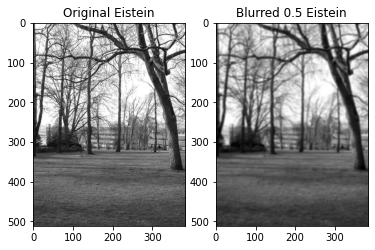

In [52]:
#img = cv2.imread("Einstein.jpg")
img = cv2.imread("parrington.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
base_img = cv2.GaussianBlur(img,(0,0),sigmaX=sigma,sigmaY=sigma) 
#base_img = BaseImg(img,sigma,blur)
plt.figure()
f,axarr = plt.subplots(1,2)
axarr[0].set_title("Original Eistein")
axarr[0].imshow(img,cmap="gray")
axarr[1].set_title("Blurred 0.5 Eistein")
axarr[1].imshow(base_img,cmap="gray")
plt.show()
octave = GetOctaveNum(base_img.shape[:2])
gaussian_kernels = GetKernels(sigma, layer_num, octave)

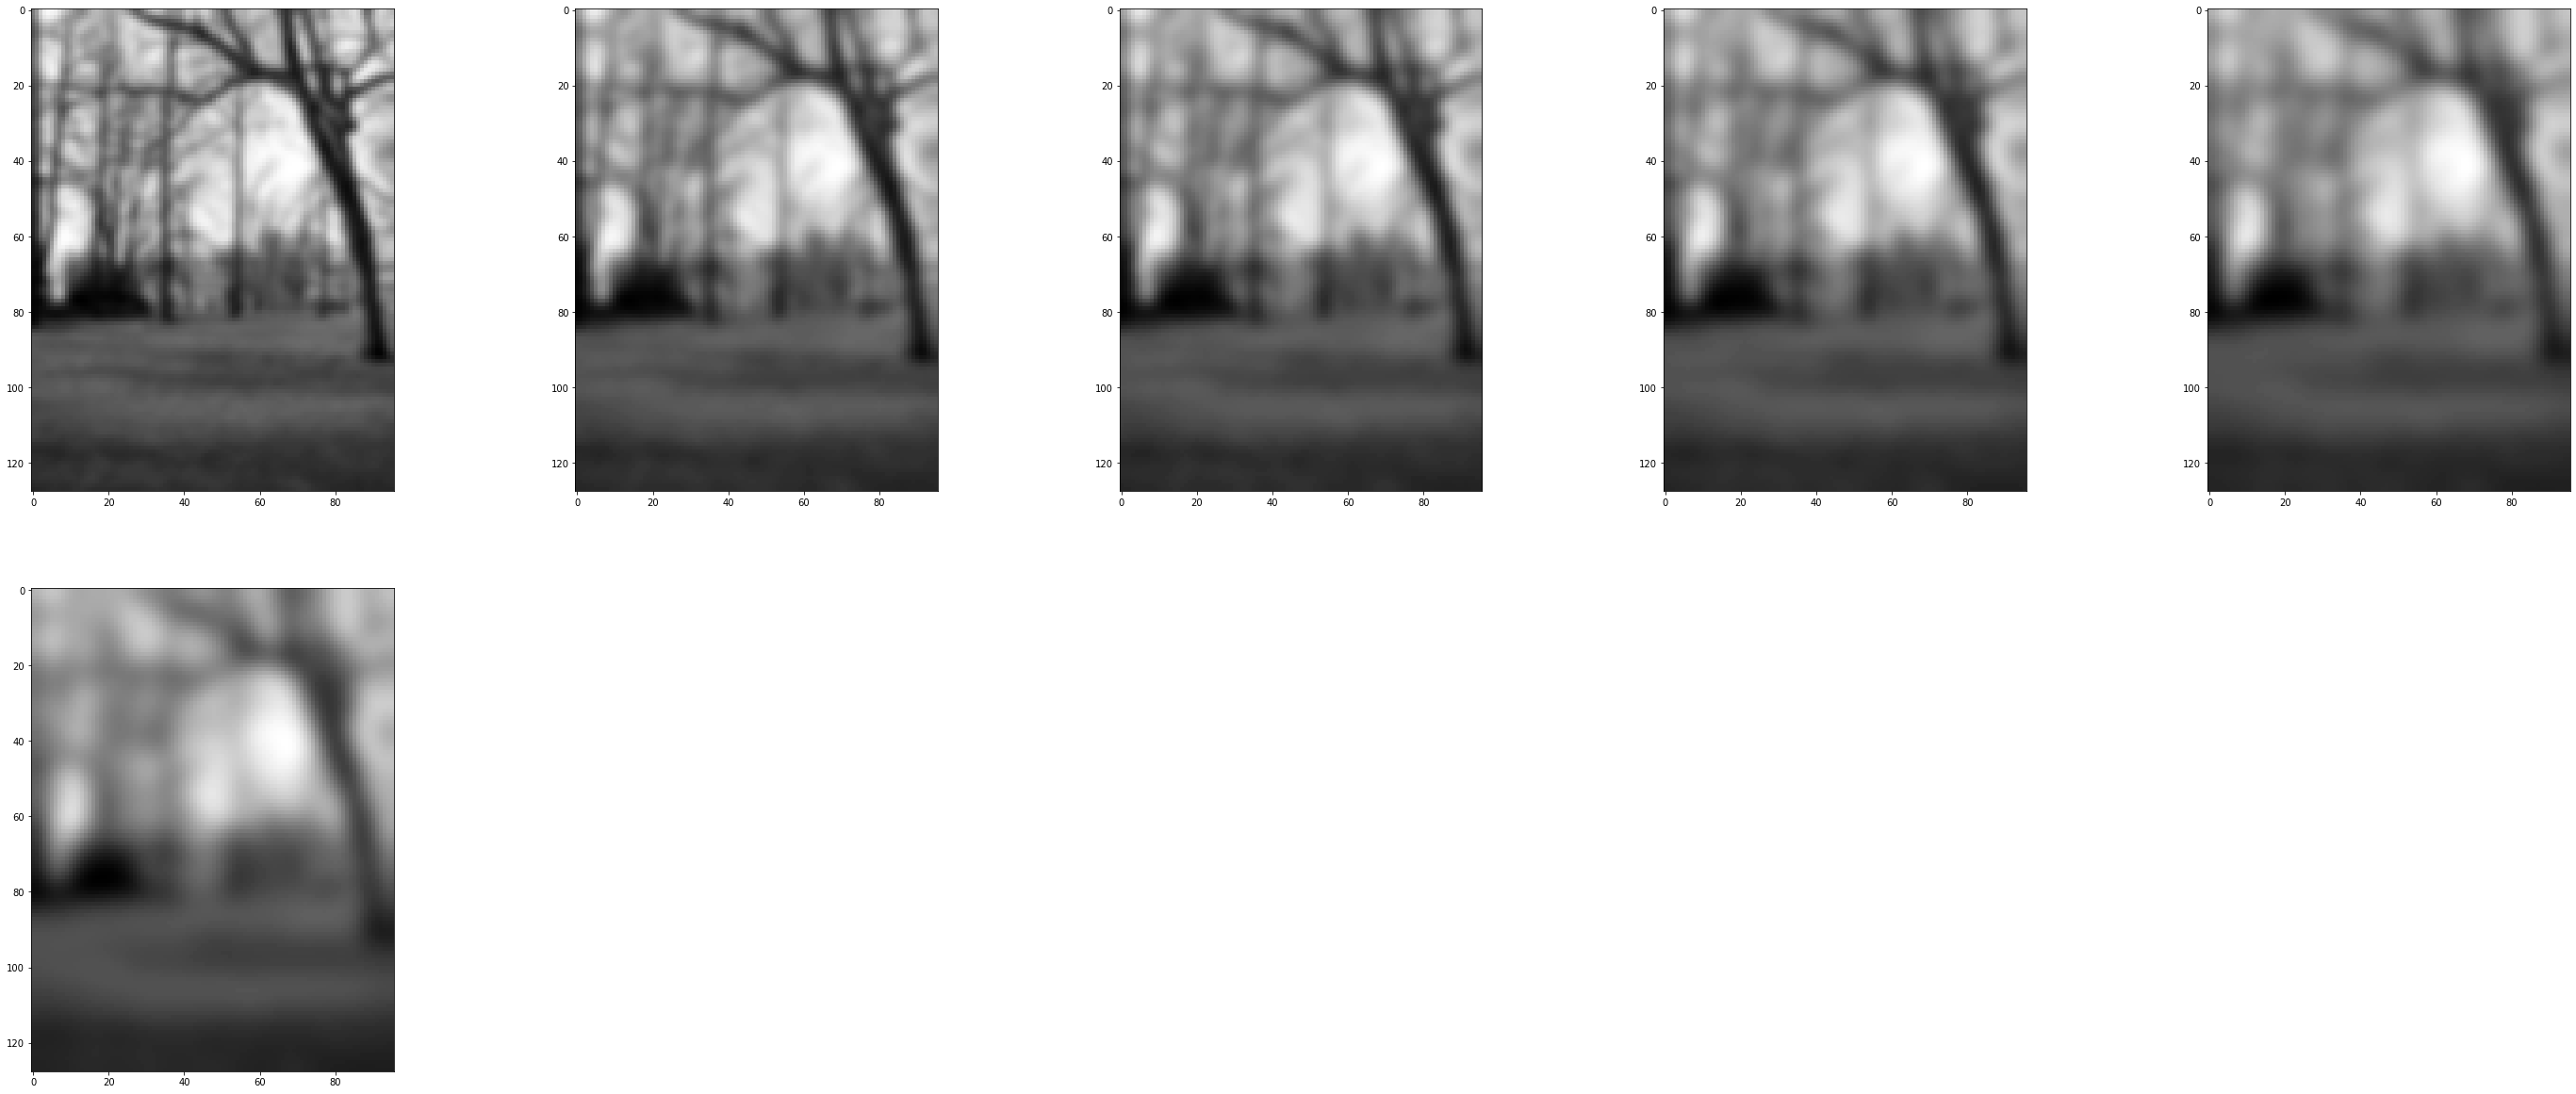

In [53]:
gaussian_pyrimid = GetPyrimid(base_img,octave, gaussian_kernels)
fig = plt.figure()
fig.set_figheight(100)
fig.set_figwidth(50)
for idx,pic in enumerate(gaussian_pyrimid[2]):
    fig.add_subplot(9, 5, idx+1)
    plt.imshow(pic,cmap='gray')
plt.show()

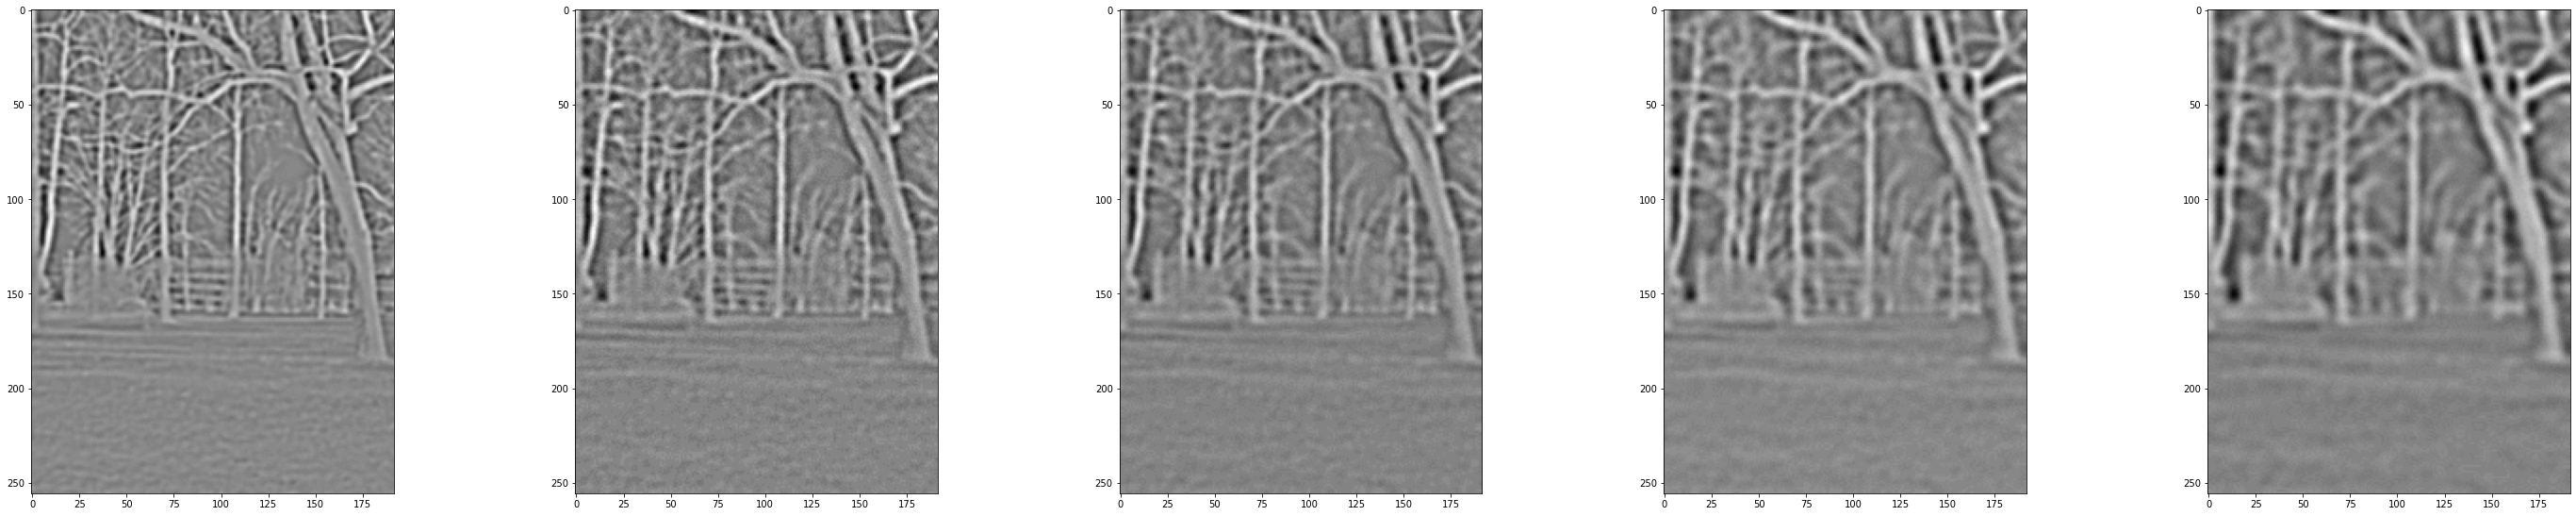

In [54]:
dog_pyrimid = GetDogPyrimid(gaussian_pyrimid)
fig = plt.figure()
fig.set_figheight(100)
fig.set_figwidth(50)
for idx,pic in enumerate(dog_pyrimid[1]):
    fig.add_subplot(9, 5, idx+1)
    plt.imshow(pic,cmap='gray')
plt.show()
np.set_printoptions(threshold=np.inf)

In [55]:
keypoints = FindExtrema(img,dog_pyrimid,layer_num)

423
423


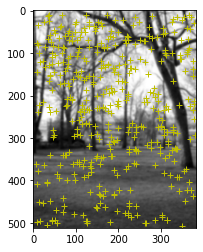

In [56]:
print(len(keypoints))
Visualize_keypoints(base_img,keypoints)

In [65]:
oriented_keypoints = Orientation_assignment(keypoints,gaussian_pyrimid)
print(len(oriented_keypoints))

8 364 (512, 384)
8 365 (512, 384)
8 366 (512, 384)
8 367 (512, 384)
8 368 (512, 384)
9 364 (512, 384)
9 365 (512, 384)
9 366 (512, 384)
9 367 (512, 384)
9 368 (512, 384)
10 364 (512, 384)
10 365 (512, 384)
10 366 (512, 384)
10 367 (512, 384)
10 368 (512, 384)
11 364 (512, 384)
11 365 (512, 384)
11 366 (512, 384)
11 367 (512, 384)
11 368 (512, 384)
12 364 (512, 384)
12 365 (512, 384)
12 366 (512, 384)
12 367 (512, 384)
12 368 (512, 384)
9 35 (512, 384)
9 36 (512, 384)
9 37 (512, 384)
9 38 (512, 384)
9 39 (512, 384)
10 35 (512, 384)
10 36 (512, 384)
10 37 (512, 384)
10 38 (512, 384)
10 39 (512, 384)
11 35 (512, 384)
11 36 (512, 384)
11 37 (512, 384)
11 38 (512, 384)
11 39 (512, 384)
12 35 (512, 384)
12 36 (512, 384)
12 37 (512, 384)
12 38 (512, 384)
12 39 (512, 384)
13 35 (512, 384)
13 36 (512, 384)
13 37 (512, 384)
13 38 (512, 384)
13 39 (512, 384)
17 326 (512, 384)
17 327 (512, 384)
17 328 (512, 384)
17 329 (512, 384)
17 330 (512, 384)
18 326 (512, 384)
18 327 (512, 384)
18 328 (512, 3

53 304 (512, 384)
53 305 (512, 384)
53 306 (512, 384)
53 307 (512, 384)
53 308 (512, 384)
54 304 (512, 384)
54 305 (512, 384)
54 306 (512, 384)
54 307 (512, 384)
54 308 (512, 384)
55 304 (512, 384)
55 305 (512, 384)
55 306 (512, 384)
55 307 (512, 384)
55 308 (512, 384)
56 304 (512, 384)
56 305 (512, 384)
56 306 (512, 384)
56 307 (512, 384)
56 308 (512, 384)
57 304 (512, 384)
57 305 (512, 384)
57 306 (512, 384)
57 307 (512, 384)
57 308 (512, 384)
57 179 (512, 384)
57 180 (512, 384)
57 181 (512, 384)
57 182 (512, 384)
57 183 (512, 384)
58 179 (512, 384)
58 180 (512, 384)
58 181 (512, 384)
58 182 (512, 384)
58 183 (512, 384)
59 179 (512, 384)
59 180 (512, 384)
59 181 (512, 384)
59 182 (512, 384)
59 183 (512, 384)
60 179 (512, 384)
60 180 (512, 384)
60 181 (512, 384)
60 182 (512, 384)
60 183 (512, 384)
61 179 (512, 384)
61 180 (512, 384)
61 181 (512, 384)
61 182 (512, 384)
61 183 (512, 384)
57 218 (512, 384)
57 219 (512, 384)
57 220 (512, 384)
57 221 (512, 384)
57 222 (512, 384)
58 218 (51

112 346 (512, 384)
112 347 (512, 384)
112 348 (512, 384)
112 349 (512, 384)
112 350 (512, 384)
113 346 (512, 384)
113 347 (512, 384)
113 348 (512, 384)
113 349 (512, 384)
113 350 (512, 384)
114 346 (512, 384)
114 347 (512, 384)
114 348 (512, 384)
114 349 (512, 384)
114 350 (512, 384)
115 346 (512, 384)
115 347 (512, 384)
115 348 (512, 384)
115 349 (512, 384)
115 350 (512, 384)
116 346 (512, 384)
116 347 (512, 384)
116 348 (512, 384)
116 349 (512, 384)
116 350 (512, 384)
113 249 (512, 384)
113 250 (512, 384)
113 251 (512, 384)
113 252 (512, 384)
113 253 (512, 384)
114 249 (512, 384)
114 250 (512, 384)
114 251 (512, 384)
114 252 (512, 384)
114 253 (512, 384)
115 249 (512, 384)
115 250 (512, 384)
115 251 (512, 384)
115 252 (512, 384)
115 253 (512, 384)
116 249 (512, 384)
116 250 (512, 384)
116 251 (512, 384)
116 252 (512, 384)
116 253 (512, 384)
117 249 (512, 384)
117 250 (512, 384)
117 251 (512, 384)
117 252 (512, 384)
117 253 (512, 384)
114 225 (512, 384)
114 226 (512, 384)
114 227 (512

192 280 (512, 384)
192 281 (512, 384)
192 282 (512, 384)
192 283 (512, 384)
192 284 (512, 384)
193 280 (512, 384)
193 281 (512, 384)
193 282 (512, 384)
193 283 (512, 384)
193 284 (512, 384)
194 280 (512, 384)
194 281 (512, 384)
194 282 (512, 384)
194 283 (512, 384)
194 284 (512, 384)
195 280 (512, 384)
195 281 (512, 384)
195 282 (512, 384)
195 283 (512, 384)
195 284 (512, 384)
196 280 (512, 384)
196 281 (512, 384)
196 282 (512, 384)
196 283 (512, 384)
196 284 (512, 384)
194 161 (512, 384)
194 162 (512, 384)
194 163 (512, 384)
194 164 (512, 384)
194 165 (512, 384)
195 161 (512, 384)
195 162 (512, 384)
195 163 (512, 384)
195 164 (512, 384)
195 165 (512, 384)
196 161 (512, 384)
196 162 (512, 384)
196 163 (512, 384)
196 164 (512, 384)
196 165 (512, 384)
197 161 (512, 384)
197 162 (512, 384)
197 163 (512, 384)
197 164 (512, 384)
197 165 (512, 384)
198 161 (512, 384)
198 162 (512, 384)
198 163 (512, 384)
198 164 (512, 384)
198 165 (512, 384)
194 219 (512, 384)
194 220 (512, 384)
194 221 (512

280 328 (512, 384)
280 329 (512, 384)
280 330 (512, 384)
280 331 (512, 384)
280 332 (512, 384)
281 328 (512, 384)
281 329 (512, 384)
281 330 (512, 384)
281 331 (512, 384)
281 332 (512, 384)
282 328 (512, 384)
282 329 (512, 384)
282 330 (512, 384)
282 331 (512, 384)
282 332 (512, 384)
283 328 (512, 384)
283 329 (512, 384)
283 330 (512, 384)
283 331 (512, 384)
283 332 (512, 384)
284 328 (512, 384)
284 329 (512, 384)
284 330 (512, 384)
284 331 (512, 384)
284 332 (512, 384)
289 148 (512, 384)
289 149 (512, 384)
289 150 (512, 384)
289 151 (512, 384)
289 152 (512, 384)
290 148 (512, 384)
290 149 (512, 384)
290 150 (512, 384)
290 151 (512, 384)
290 152 (512, 384)
291 148 (512, 384)
291 149 (512, 384)
291 150 (512, 384)
291 151 (512, 384)
291 152 (512, 384)
292 148 (512, 384)
292 149 (512, 384)
292 150 (512, 384)
292 151 (512, 384)
292 152 (512, 384)
293 148 (512, 384)
293 149 (512, 384)
293 150 (512, 384)
293 151 (512, 384)
293 152 (512, 384)
289 132 (512, 384)
289 133 (512, 384)
289 134 (512

368 133 (512, 384)
368 134 (512, 384)
368 135 (512, 384)
368 136 (512, 384)
368 137 (512, 384)
369 133 (512, 384)
369 134 (512, 384)
369 135 (512, 384)
369 136 (512, 384)
369 137 (512, 384)
370 133 (512, 384)
370 134 (512, 384)
370 135 (512, 384)
370 136 (512, 384)
370 137 (512, 384)
371 133 (512, 384)
371 134 (512, 384)
371 135 (512, 384)
371 136 (512, 384)
371 137 (512, 384)
372 133 (512, 384)
372 134 (512, 384)
372 135 (512, 384)
372 136 (512, 384)
372 137 (512, 384)
370 358 (512, 384)
370 359 (512, 384)
370 360 (512, 384)
370 361 (512, 384)
370 362 (512, 384)
371 358 (512, 384)
371 359 (512, 384)
371 360 (512, 384)
371 361 (512, 384)
371 362 (512, 384)
372 358 (512, 384)
372 359 (512, 384)
372 360 (512, 384)
372 361 (512, 384)
372 362 (512, 384)
373 358 (512, 384)
373 359 (512, 384)
373 360 (512, 384)
373 361 (512, 384)
373 362 (512, 384)
374 358 (512, 384)
374 359 (512, 384)
374 360 (512, 384)
374 361 (512, 384)
374 362 (512, 384)
374 188 (512, 384)
374 189 (512, 384)
374 190 (512

499 124 (512, 384)
499 125 (512, 384)
499 126 (512, 384)
499 127 (512, 384)
499 128 (512, 384)
500 124 (512, 384)
500 125 (512, 384)
500 126 (512, 384)
500 127 (512, 384)
500 128 (512, 384)
501 124 (512, 384)
501 125 (512, 384)
501 126 (512, 384)
501 127 (512, 384)
501 128 (512, 384)
502 124 (512, 384)
502 125 (512, 384)
502 126 (512, 384)
502 127 (512, 384)
502 128 (512, 384)
503 124 (512, 384)
503 125 (512, 384)
503 126 (512, 384)
503 127 (512, 384)
503 128 (512, 384)
505 349 (512, 384)
505 350 (512, 384)
505 351 (512, 384)
505 352 (512, 384)
505 353 (512, 384)
506 349 (512, 384)
506 350 (512, 384)
506 351 (512, 384)
506 352 (512, 384)
506 353 (512, 384)
507 349 (512, 384)
507 350 (512, 384)
507 351 (512, 384)
507 352 (512, 384)
507 353 (512, 384)
508 349 (512, 384)
508 350 (512, 384)
508 351 (512, 384)
508 352 (512, 384)
508 353 (512, 384)
509 349 (512, 384)
509 350 (512, 384)
509 351 (512, 384)
509 352 (512, 384)
509 353 (512, 384)
9 65 (512, 384)
9 66 (512, 384)
9 67 (512, 384)
9 

193 176 (512, 384)
193 177 (512, 384)
193 178 (512, 384)
193 179 (512, 384)
193 180 (512, 384)
194 176 (512, 384)
194 177 (512, 384)
194 178 (512, 384)
194 179 (512, 384)
194 180 (512, 384)
208 88 (512, 384)
208 89 (512, 384)
208 90 (512, 384)
208 91 (512, 384)
208 92 (512, 384)
209 88 (512, 384)
209 89 (512, 384)
209 90 (512, 384)
209 91 (512, 384)
209 92 (512, 384)
210 88 (512, 384)
210 89 (512, 384)
210 90 (512, 384)
210 91 (512, 384)
210 92 (512, 384)
211 88 (512, 384)
211 89 (512, 384)
211 90 (512, 384)
211 91 (512, 384)
211 92 (512, 384)
212 88 (512, 384)
212 89 (512, 384)
212 90 (512, 384)
212 91 (512, 384)
212 92 (512, 384)
208 123 (512, 384)
208 124 (512, 384)
208 125 (512, 384)
208 126 (512, 384)
208 127 (512, 384)
209 123 (512, 384)
209 124 (512, 384)
209 125 (512, 384)
209 126 (512, 384)
209 127 (512, 384)
210 123 (512, 384)
210 124 (512, 384)
210 125 (512, 384)
210 126 (512, 384)
210 127 (512, 384)
211 123 (512, 384)
211 124 (512, 384)
211 125 (512, 384)
211 126 (512, 384)

338 69 (512, 384)
338 70 (512, 384)
338 71 (512, 384)
338 72 (512, 384)
338 73 (512, 384)
339 69 (512, 384)
339 70 (512, 384)
339 71 (512, 384)
339 72 (512, 384)
339 73 (512, 384)
340 69 (512, 384)
340 70 (512, 384)
340 71 (512, 384)
340 72 (512, 384)
340 73 (512, 384)
341 69 (512, 384)
341 70 (512, 384)
341 71 (512, 384)
341 72 (512, 384)
341 73 (512, 384)
342 69 (512, 384)
342 70 (512, 384)
342 71 (512, 384)
342 72 (512, 384)
342 73 (512, 384)
339 72 (512, 384)
339 73 (512, 384)
339 74 (512, 384)
339 75 (512, 384)
339 76 (512, 384)
340 72 (512, 384)
340 73 (512, 384)
340 74 (512, 384)
340 75 (512, 384)
340 76 (512, 384)
341 72 (512, 384)
341 73 (512, 384)
341 74 (512, 384)
341 75 (512, 384)
341 76 (512, 384)
342 72 (512, 384)
342 73 (512, 384)
342 74 (512, 384)
342 75 (512, 384)
342 76 (512, 384)
343 72 (512, 384)
343 73 (512, 384)
343 74 (512, 384)
343 75 (512, 384)
343 76 (512, 384)
340 147 (512, 384)
340 148 (512, 384)
340 149 (512, 384)
340 150 (512, 384)
340 151 (512, 384)
341 1

477 92 (512, 384)
477 93 (512, 384)
477 94 (512, 384)
477 95 (512, 384)
477 96 (512, 384)
478 92 (512, 384)
478 93 (512, 384)
478 94 (512, 384)
478 95 (512, 384)
478 96 (512, 384)
479 92 (512, 384)
479 93 (512, 384)
479 94 (512, 384)
479 95 (512, 384)
479 96 (512, 384)
480 92 (512, 384)
480 93 (512, 384)
480 94 (512, 384)
480 95 (512, 384)
480 96 (512, 384)
481 92 (512, 384)
481 93 (512, 384)
481 94 (512, 384)
481 95 (512, 384)
481 96 (512, 384)
479 300 (512, 384)
479 301 (512, 384)
479 302 (512, 384)
479 303 (512, 384)
479 304 (512, 384)
480 300 (512, 384)
480 301 (512, 384)
480 302 (512, 384)
480 303 (512, 384)
480 304 (512, 384)
481 300 (512, 384)
481 301 (512, 384)
481 302 (512, 384)
481 303 (512, 384)
481 304 (512, 384)
482 300 (512, 384)
482 301 (512, 384)
482 302 (512, 384)
482 303 (512, 384)
482 304 (512, 384)
483 300 (512, 384)
483 301 (512, 384)
483 302 (512, 384)
483 303 (512, 384)
483 304 (512, 384)
492 41 (512, 384)
492 42 (512, 384)
492 43 (512, 384)
492 44 (512, 384)
492

27 91 (256, 192)
27 92 (256, 192)
27 93 (256, 192)
27 94 (256, 192)
27 95 (256, 192)
27 96 (256, 192)
27 97 (256, 192)
28 91 (256, 192)
28 92 (256, 192)
28 93 (256, 192)
28 94 (256, 192)
28 95 (256, 192)
28 96 (256, 192)
28 97 (256, 192)
29 91 (256, 192)
29 92 (256, 192)
29 93 (256, 192)
29 94 (256, 192)
29 95 (256, 192)
29 96 (256, 192)
29 97 (256, 192)
30 91 (256, 192)
30 92 (256, 192)
30 93 (256, 192)
30 94 (256, 192)
30 95 (256, 192)
30 96 (256, 192)
30 97 (256, 192)
31 91 (256, 192)
31 92 (256, 192)
31 93 (256, 192)
31 94 (256, 192)
31 95 (256, 192)
31 96 (256, 192)
31 97 (256, 192)
32 91 (256, 192)
32 92 (256, 192)
32 93 (256, 192)
32 94 (256, 192)
32 95 (256, 192)
32 96 (256, 192)
32 97 (256, 192)
33 91 (256, 192)
33 92 (256, 192)
33 93 (256, 192)
33 94 (256, 192)
33 95 (256, 192)
33 96 (256, 192)
33 97 (256, 192)
30 14 (256, 192)
30 15 (256, 192)
30 16 (256, 192)
30 17 (256, 192)
30 18 (256, 192)
30 19 (256, 192)
30 20 (256, 192)
31 14 (256, 192)
31 15 (256, 192)
31 16 (256, 19

61 131 (256, 192)
61 132 (256, 192)
61 133 (256, 192)
61 134 (256, 192)
62 128 (256, 192)
62 129 (256, 192)
62 130 (256, 192)
62 131 (256, 192)
62 132 (256, 192)
62 133 (256, 192)
62 134 (256, 192)
63 128 (256, 192)
63 129 (256, 192)
63 130 (256, 192)
63 131 (256, 192)
63 132 (256, 192)
63 133 (256, 192)
63 134 (256, 192)
60 14 (256, 192)
60 15 (256, 192)
60 16 (256, 192)
60 17 (256, 192)
60 18 (256, 192)
60 19 (256, 192)
60 20 (256, 192)
61 14 (256, 192)
61 15 (256, 192)
61 16 (256, 192)
61 17 (256, 192)
61 18 (256, 192)
61 19 (256, 192)
61 20 (256, 192)
62 14 (256, 192)
62 15 (256, 192)
62 16 (256, 192)
62 17 (256, 192)
62 18 (256, 192)
62 19 (256, 192)
62 20 (256, 192)
63 14 (256, 192)
63 15 (256, 192)
63 16 (256, 192)
63 17 (256, 192)
63 18 (256, 192)
63 19 (256, 192)
63 20 (256, 192)
64 14 (256, 192)
64 15 (256, 192)
64 16 (256, 192)
64 17 (256, 192)
64 18 (256, 192)
64 19 (256, 192)
64 20 (256, 192)
65 14 (256, 192)
65 15 (256, 192)
65 16 (256, 192)
65 17 (256, 192)
65 18 (256, 1

108 53 (256, 192)
108 54 (256, 192)
108 55 (256, 192)
108 56 (256, 192)
108 57 (256, 192)
108 58 (256, 192)
108 59 (256, 192)
109 53 (256, 192)
109 54 (256, 192)
109 55 (256, 192)
109 56 (256, 192)
109 57 (256, 192)
109 58 (256, 192)
109 59 (256, 192)
110 53 (256, 192)
110 54 (256, 192)
110 55 (256, 192)
110 56 (256, 192)
110 57 (256, 192)
110 58 (256, 192)
110 59 (256, 192)
111 53 (256, 192)
111 54 (256, 192)
111 55 (256, 192)
111 56 (256, 192)
111 57 (256, 192)
111 58 (256, 192)
111 59 (256, 192)
112 53 (256, 192)
112 54 (256, 192)
112 55 (256, 192)
112 56 (256, 192)
112 57 (256, 192)
112 58 (256, 192)
112 59 (256, 192)
113 53 (256, 192)
113 54 (256, 192)
113 55 (256, 192)
113 56 (256, 192)
113 57 (256, 192)
113 58 (256, 192)
113 59 (256, 192)
114 53 (256, 192)
114 54 (256, 192)
114 55 (256, 192)
114 56 (256, 192)
114 57 (256, 192)
114 58 (256, 192)
114 59 (256, 192)
114 63 (256, 192)
114 64 (256, 192)
114 65 (256, 192)
114 66 (256, 192)
114 67 (256, 192)
114 68 (256, 192)
114 69 (25

151 97 (256, 192)
152 91 (256, 192)
152 92 (256, 192)
152 93 (256, 192)
152 94 (256, 192)
152 95 (256, 192)
152 96 (256, 192)
152 97 (256, 192)
153 91 (256, 192)
153 92 (256, 192)
153 93 (256, 192)
153 94 (256, 192)
153 95 (256, 192)
153 96 (256, 192)
153 97 (256, 192)
154 91 (256, 192)
154 92 (256, 192)
154 93 (256, 192)
154 94 (256, 192)
154 95 (256, 192)
154 96 (256, 192)
154 97 (256, 192)
155 91 (256, 192)
155 92 (256, 192)
155 93 (256, 192)
155 94 (256, 192)
155 95 (256, 192)
155 96 (256, 192)
155 97 (256, 192)
156 91 (256, 192)
156 92 (256, 192)
156 93 (256, 192)
156 94 (256, 192)
156 95 (256, 192)
156 96 (256, 192)
156 97 (256, 192)
154 155 (256, 192)
154 156 (256, 192)
154 157 (256, 192)
154 158 (256, 192)
154 159 (256, 192)
154 160 (256, 192)
154 161 (256, 192)
155 155 (256, 192)
155 156 (256, 192)
155 157 (256, 192)
155 158 (256, 192)
155 159 (256, 192)
155 160 (256, 192)
155 161 (256, 192)
156 155 (256, 192)
156 156 (256, 192)
156 157 (256, 192)
156 158 (256, 192)
156 159 (2

246 1 (256, 192)
246 2 (256, 192)
246 3 (256, 192)
246 4 (256, 192)
246 5 (256, 192)
246 6 (256, 192)
246 7 (256, 192)
247 1 (256, 192)
247 2 (256, 192)
247 3 (256, 192)
247 4 (256, 192)
247 5 (256, 192)
247 6 (256, 192)
247 7 (256, 192)
248 1 (256, 192)
248 2 (256, 192)
248 3 (256, 192)
248 4 (256, 192)
248 5 (256, 192)
248 6 (256, 192)
248 7 (256, 192)
249 1 (256, 192)
249 2 (256, 192)
249 3 (256, 192)
249 4 (256, 192)
249 5 (256, 192)
249 6 (256, 192)
249 7 (256, 192)
250 1 (256, 192)
250 2 (256, 192)
250 3 (256, 192)
250 4 (256, 192)
250 5 (256, 192)
250 6 (256, 192)
250 7 (256, 192)
251 1 (256, 192)
251 2 (256, 192)
251 3 (256, 192)
251 4 (256, 192)
251 5 (256, 192)
251 6 (256, 192)
251 7 (256, 192)
252 1 (256, 192)
252 2 (256, 192)
252 3 (256, 192)
252 4 (256, 192)
252 5 (256, 192)
252 6 (256, 192)
252 7 (256, 192)
247 128 (256, 192)
247 129 (256, 192)
247 130 (256, 192)
247 131 (256, 192)
247 132 (256, 192)
247 133 (256, 192)
247 134 (256, 192)
248 128 (256, 192)
248 129 (256, 1

98 137 (256, 192)
98 138 (256, 192)
98 139 (256, 192)
98 140 (256, 192)
99 134 (256, 192)
99 135 (256, 192)
99 136 (256, 192)
99 137 (256, 192)
99 138 (256, 192)
99 139 (256, 192)
99 140 (256, 192)
100 129 (256, 192)
100 130 (256, 192)
100 131 (256, 192)
100 132 (256, 192)
100 133 (256, 192)
100 134 (256, 192)
100 135 (256, 192)
101 129 (256, 192)
101 130 (256, 192)
101 131 (256, 192)
101 132 (256, 192)
101 133 (256, 192)
101 134 (256, 192)
101 135 (256, 192)
102 129 (256, 192)
102 130 (256, 192)
102 131 (256, 192)
102 132 (256, 192)
102 133 (256, 192)
102 134 (256, 192)
102 135 (256, 192)
103 129 (256, 192)
103 130 (256, 192)
103 131 (256, 192)
103 132 (256, 192)
103 133 (256, 192)
103 134 (256, 192)
103 135 (256, 192)
104 129 (256, 192)
104 130 (256, 192)
104 131 (256, 192)
104 132 (256, 192)
104 133 (256, 192)
104 134 (256, 192)
104 135 (256, 192)
105 129 (256, 192)
105 130 (256, 192)
105 131 (256, 192)
105 132 (256, 192)
105 133 (256, 192)
105 134 (256, 192)
105 135 (256, 192)
106 

250 13 (256, 192)
250 14 (256, 192)
250 15 (256, 192)
250 16 (256, 192)
250 17 (256, 192)
250 18 (256, 192)
250 19 (256, 192)
251 13 (256, 192)
251 14 (256, 192)
251 15 (256, 192)
251 16 (256, 192)
251 17 (256, 192)
251 18 (256, 192)
251 19 (256, 192)
252 13 (256, 192)
252 14 (256, 192)
252 15 (256, 192)
252 16 (256, 192)
252 17 (256, 192)
252 18 (256, 192)
252 19 (256, 192)
253 13 (256, 192)
253 14 (256, 192)
253 15 (256, 192)
253 16 (256, 192)
253 17 (256, 192)
253 18 (256, 192)
253 19 (256, 192)
254 13 (256, 192)
254 14 (256, 192)
254 15 (256, 192)
254 16 (256, 192)
254 17 (256, 192)
254 18 (256, 192)
254 19 (256, 192)
255 13 (256, 192)
255 14 (256, 192)
255 15 (256, 192)
255 16 (256, 192)
255 17 (256, 192)
255 18 (256, 192)
255 19 (256, 192)
256 13 (256, 192)
256 14 (256, 192)
256 15 (256, 192)
256 16 (256, 192)
256 17 (256, 192)
256 18 (256, 192)
256 19 (256, 192)
0 89 (128, 96)
0 90 (128, 96)
0 91 (128, 96)
0 92 (128, 96)
0 93 (128, 96)
0 94 (128, 96)
0 95 (128, 96)
1 89 (128, 96

41 56 (128, 96)
41 57 (128, 96)
42 51 (128, 96)
42 52 (128, 96)
42 53 (128, 96)
42 54 (128, 96)
42 55 (128, 96)
42 56 (128, 96)
42 57 (128, 96)
43 51 (128, 96)
43 52 (128, 96)
43 53 (128, 96)
43 54 (128, 96)
43 55 (128, 96)
43 56 (128, 96)
43 57 (128, 96)
44 51 (128, 96)
44 52 (128, 96)
44 53 (128, 96)
44 54 (128, 96)
44 55 (128, 96)
44 56 (128, 96)
44 57 (128, 96)
45 51 (128, 96)
45 52 (128, 96)
45 53 (128, 96)
45 54 (128, 96)
45 55 (128, 96)
45 56 (128, 96)
45 57 (128, 96)
43 40 (128, 96)
43 41 (128, 96)
43 42 (128, 96)
43 43 (128, 96)
43 44 (128, 96)
43 45 (128, 96)
43 46 (128, 96)
44 40 (128, 96)
44 41 (128, 96)
44 42 (128, 96)
44 43 (128, 96)
44 44 (128, 96)
44 45 (128, 96)
44 46 (128, 96)
45 40 (128, 96)
45 41 (128, 96)
45 42 (128, 96)
45 43 (128, 96)
45 44 (128, 96)
45 45 (128, 96)
45 46 (128, 96)
46 40 (128, 96)
46 41 (128, 96)
46 42 (128, 96)
46 43 (128, 96)
46 44 (128, 96)
46 45 (128, 96)
46 46 (128, 96)
47 40 (128, 96)
47 41 (128, 96)
47 42 (128, 96)
47 43 (128, 96)
47 44 (1

7 3 (32, 24)
7 4 (32, 24)
8 0 (32, 24)
8 1 (32, 24)
8 2 (32, 24)
8 3 (32, 24)
8 4 (32, 24)
9 0 (32, 24)
9 1 (32, 24)
9 2 (32, 24)
9 3 (32, 24)
9 4 (32, 24)
10 0 (32, 24)
10 1 (32, 24)
10 2 (32, 24)
10 3 (32, 24)
10 4 (32, 24)
11 0 (32, 24)
11 1 (32, 24)
11 2 (32, 24)
11 3 (32, 24)
11 4 (32, 24)
15 13 (32, 24)
15 14 (32, 24)
15 15 (32, 24)
15 16 (32, 24)
15 17 (32, 24)
16 13 (32, 24)
16 14 (32, 24)
16 15 (32, 24)
16 16 (32, 24)
16 17 (32, 24)
17 13 (32, 24)
17 14 (32, 24)
17 15 (32, 24)
17 16 (32, 24)
17 17 (32, 24)
18 13 (32, 24)
18 14 (32, 24)
18 15 (32, 24)
18 16 (32, 24)
18 17 (32, 24)
19 13 (32, 24)
19 14 (32, 24)
19 15 (32, 24)
19 16 (32, 24)
19 17 (32, 24)
610


In [70]:
descriptors = GenerateDescriptors(oriented_keypoints,gaussian_pyrimid)
print(descriptors.shape)

69.6235580444336
62.102725982666016
58.781593322753906
61.26020050048828
66.29734802246094
58.13401794433594
54.637535095214844
55.840301513671875
65.46227264404297
58.81502151489258
54.090274810791016
51.95295333862305
67.79652404785156
60.422157287597656
53.84181213378906
52.1250114440918
69.6235580444336
62.102725982666016
58.781593322753906
61.26020050048828
66.29734802246094
58.13401794433594
54.637535095214844
55.840301513671875
65.46227264404297
58.81502151489258
54.090274810791016
51.95295333862305
67.79652404785156
60.422157287597656
53.84181213378906
52.1250114440918
69.6235580444336
62.102725982666016
58.781593322753906
61.26020050048828
66.29734802246094
58.13401794433594
54.637535095214844
55.840301513671875
65.46227264404297
58.81502151489258
54.090274810791016
51.95295333862305
67.79652404785156
60.422157287597656
53.84181213378906
52.1250114440918
69.6235580444336
62.102725982666016
58.781593322753906
61.26020050048828
66.29734802246094
58.13401794433594
54.637535095214

49.39870071411133
41.98720932006836
15.945395469665527
59.534454345703125
54.46232223510742
36.869895935058594
323.1301040649414
90.0
61.3895378112793
55.30484390258789
56.309932708740234
59.743560791015625
51.842769622802734
47.72631072998047
35.53767776489258
56.309932708740234
49.39870071411133
41.98720932006836
15.945395469665527
59.534454345703125
54.46232223510742
36.869895935058594
323.1301040649414
90.0
61.3895378112793
55.30484390258789
56.309932708740234
59.743560791015625
51.842769622802734
47.72631072998047
35.53767776489258
56.309932708740234
49.39870071411133
41.98720932006836
15.945395469665527
59.534454345703125
54.46232223510742
36.869895935058594
323.1301040649414
90.0
61.3895378112793
55.30484390258789
56.309932708740234
59.743560791015625
51.842769622802734
47.72631072998047
35.53767776489258
56.309932708740234
49.39870071411133
41.98720932006836
15.945395469665527
59.534454345703125
54.46232223510742
36.869895935058594
323.1301040649414
90.0
61.3895378112793
55.304

329.0362434387207
315.0
302.61924743652344
294.77513885498047
318.9909133911133
308.367488861084
299.74488830566406
293.42869567871094
305.5376777648926
295.7099609375
289.53665924072266
289.53665924072266
279.8658142089844
278.1301040649414
279.4623260498047
280.9540710449219
329.0362434387207
315.0
302.61924743652344
294.77513885498047
318.9909133911133
308.367488861084
299.74488830566406
293.42869567871094
305.5376777648926
295.7099609375
289.53665924072266
289.53665924072266
279.8658142089844
278.1301040649414
279.4623260498047
280.9540710449219
329.0362434387207
315.0
302.61924743652344
294.77513885498047
318.9909133911133
308.367488861084
299.74488830566406
293.42869567871094
305.5376777648926
295.7099609375
289.53665924072266
289.53665924072266
279.8658142089844
278.1301040649414
279.4623260498047
280.9540710449219
329.0362434387207
315.0
302.61924743652344
294.77513885498047
318.9909133911133
308.367488861084
299.74488830566406
293.42869567871094
305.5376777648926
295.709960937

25.016891479492188
35.83765411376953
43.2642936706543
40.91438293457031
299.74488830566406
23.198589324951172
48.01278305053711
42.709388732910156
350.5376787185669
23.629375457763672
33.02386474609375
34.2868766784668
7.125016212463379
30.068580627441406
36.027374267578125
34.2868766784668
25.016891479492188
35.83765411376953
43.2642936706543
40.91438293457031
299.74488830566406
23.198589324951172
48.01278305053711
42.709388732910156
350.5376787185669
23.629375457763672
33.02386474609375
34.2868766784668
7.125016212463379
30.068580627441406
36.027374267578125
34.2868766784668
25.016891479492188
35.83765411376953
43.2642936706543
40.91438293457031
299.74488830566406
23.198589324951172
48.01278305053711
42.709388732910156
350.5376787185669
23.629375457763672
33.02386474609375
34.2868766784668
7.125016212463379
30.068580627441406
36.027374267578125
34.2868766784668
25.016891479492188
35.83765411376953
43.2642936706543
40.91438293457031
299.74488830566406
23.198589324951172
48.01278305053

317.6025619506836
317.29061126708984
324.4623222351074
321.3401908874512
317.91083908081055
316.21887969970703
304.6951560974121
282.52881622314453
216.86990356445312
149.03623962402344
321.3401908874512
316.6365776062012
309.2894096374512
270.0
324.78240966796875
320.19443130493164
317.6025619506836
317.29061126708984
324.4623222351074
321.3401908874512
317.91083908081055
316.21887969970703
304.6951560974121
282.52881622314453
216.86990356445312
149.03623962402344
321.3401908874512
316.6365776062012
309.2894096374512
270.0
324.78240966796875
320.19443130493164
317.6025619506836
317.29061126708984
324.4623222351074
321.3401908874512
317.91083908081055
316.21887969970703
304.6951560974121
282.52881622314453
216.86990356445312
149.03623962402344
321.3401908874512
316.6365776062012
309.2894096374512
270.0
324.78240966796875
320.19443130493164
317.6025619506836
317.29061126708984
324.4623222351074
321.3401908874512
317.91083908081055
316.21887969970703
304.6951560974121
282.52881622314453


150.25511169433594
135.0
0.0
315.0
116.5650405883789
99.46231842041016
45.0
315.0
100.30484008789062
82.8749771118164
53.13010025024414
315.0
90.0
79.69514465332031
53.13010025024414
296.5650520324707
150.25511169433594
135.0
0.0
315.0
116.5650405883789
99.46231842041016
45.0
315.0
100.30484008789062
82.8749771118164
53.13010025024414
315.0
90.0
79.69514465332031
53.13010025024414
296.5650520324707
150.25511169433594
135.0
0.0
315.0
116.5650405883789
99.46231842041016
45.0
315.0
100.30484008789062
82.8749771118164
53.13010025024414
315.0
90.0
79.69514465332031
53.13010025024414
296.5650520324707
150.25511169433594
135.0
0.0
315.0
116.5650405883789
99.46231842041016
45.0
315.0
100.30484008789062
82.8749771118164
53.13010025024414
315.0
90.0
79.69514465332031
53.13010025024414
296.5650520324707
150.25511169433594
135.0
0.0
315.0
116.5650405883789
99.46231842041016
45.0
315.0
100.30484008789062
82.8749771118164
53.13010025024414
315.0
90.0
79.69514465332031
53.13010025024414
296.565052032

215.53768920898438
230.19442749023438
146.30992126464844
96.70983123779297
203.1986083984375
210.96376037597656
135.0
97.12501525878906
210.96376037597656
206.56504821777344
120.96375274658203
96.70983123779297
225.0
206.56504821777344
111.80139923095703
96.70983123779297
215.53768920898438
230.19442749023438
146.30992126464844
96.70983123779297
203.1986083984375
210.96376037597656
135.0
97.12501525878906
210.96376037597656
206.56504821777344
120.96375274658203
96.70983123779297
225.0
206.56504821777344
111.80139923095703
96.70983123779297
215.53768920898438
230.19442749023438
146.30992126464844
96.70983123779297
203.1986083984375
210.96376037597656
135.0
97.12501525878906
210.96376037597656
206.56504821777344
120.96375274658203
96.70983123779297
225.0
206.56504821777344
111.80139923095703
96.70983123779297
215.53768920898438
230.19442749023438
146.30992126464844
96.70983123779297
203.1986083984375
210.96376037597656
135.0
97.12501525878906
210.96376037597656
206.56504821777344
120.963

147.99461364746094
165.9637451171875
161.56504821777344
147.99461364746094
150.94540405273438
167.47119140625
194.0362548828125
164.05459594726562
158.19857788085938
170.5376739501953
147.99461364746094
150.94540405273438
158.19857788085938
163.30075073242188
159.44393920898438
150.94540405273438
147.99461364746094
165.9637451171875
161.56504821777344
147.99461364746094
150.94540405273438
167.47119140625
194.0362548828125
164.05459594726562
158.19857788085938
170.5376739501953
150.94540405273438
198.43495178222656
240.255126953125
243.4349594116211
160.20111083984375
174.80557250976562
193.2405242919922
208.30076599121094
163.0091552734375
169.6951446533203
175.91436767578125
182.60256958007812
161.56504821777344
164.87599182128906
168.36634826660156
172.4053497314453
150.94540405273438
198.43495178222656
240.255126953125
243.4349594116211
160.20111083984375
174.80557250976562
193.2405242919922
208.30076599121094
163.0091552734375
169.6951446533203
175.91436767578125
182.60256958007812

329.0362434387207
329.7435646057129
330.9453983306885
344.0546045303345
322.4314079284668
320.19443130493164
325.00798416137695
343.30075454711914
306.0273780822754
308.6598091125488
318.81407928466797
339.44395637512207
294.44395446777344
291.8014144897461
305.5376777648926
338.1985912322998
329.0362434387207
329.7435646057129
330.9453983306885
344.0546045303345
322.4314079284668
320.19443130493164
325.00798416137695
343.30075454711914
306.0273780822754
308.6598091125488
318.81407928466797
339.44395637512207
294.44395446777344
291.8014144897461
305.5376777648926
338.1985912322998
329.0362434387207
329.7435646057129
330.9453983306885
344.0546045303345
322.4314079284668
320.19443130493164
325.00798416137695
343.30075454711914
306.0273780822754
308.6598091125488
318.81407928466797
339.44395637512207
294.44395446777344
291.8014144897461
305.5376777648926
338.1985912322998
329.0362434387207
329.7435646057129
330.9453983306885
344.0546045303345
322.4314079284668
320.19443130493164
325.00798

46.84761047363281
53.13010025024414
66.80140686035156
34.508522033691406
45.0
63.4349479675293
161.56504821777344
26.56505012512207
30.963756561279297
0.0
216.86990356445312
45.0
46.46879959106445
50.194427490234375
45.0
40.364532470703125
46.84761047363281
53.13010025024414
66.80140686035156
34.508522033691406
45.0
63.4349479675293
161.56504821777344
26.56505012512207
30.963756561279297
0.0
216.86990356445312
45.0
46.46879959106445
50.194427490234375
45.0
40.364532470703125
46.84761047363281
53.13010025024414
66.80140686035156
34.508522033691406
45.0
63.4349479675293
161.56504821777344
26.56505012512207
30.963756561279297
0.0
216.86990356445312
45.0
46.46879959106445
50.194427490234375
45.0
40.364532470703125
46.84761047363281
53.13010025024414
66.80140686035156
34.508522033691406
45.0
63.4349479675293
161.56504821777344
26.56505012512207
30.963756561279297
0.0
216.86990356445312
45.0
46.46879959106445
50.194427490234375
45.0
40.364532470703125
46.84761047363281
53.13010025024414
66.8

294.77513885498047
286.3895492553711
90.0
108.43494415283203
80.53767395019531
60.94539260864258
90.0
75.96375274658203
66.03750610351562
61.699241638183594
45.0
60.25511169433594
63.4349479675293
60.25511169433594
38.65980911254883
48.8140754699707
58.392494201660156
61.927513122558594
90.0
108.43494415283203
80.53767395019531
60.94539260864258
90.0
75.96375274658203
66.03750610351562
61.699241638183594
45.0
60.25511169433594
63.4349479675293
60.25511169433594
38.65980911254883
48.8140754699707
58.392494201660156
61.927513122558594
90.0
108.43494415283203
80.53767395019531
60.94539260864258
90.0
75.96375274658203
66.03750610351562
61.699241638183594
45.0
60.25511169433594
63.4349479675293
60.25511169433594
38.65980911254883
48.8140754699707
58.392494201660156
61.927513122558594
90.0
108.43494415283203
80.53767395019531
60.94539260864258
90.0
75.96375274658203
66.03750610351562
61.699241638183594
45.0
60.25511169433594
63.4349479675293
60.25511169433594
38.65980911254883
48.81407546997

46.0809211730957
42.27368927001953
45.0
46.16913604736328
49.39870071411133
220.31411743164062
222.13760375976562
219.8055877685547
45.0
216.86990356445312
218.65982055664062
45.0
43.53119659423828
206.56504821777344
45.0
46.46879959106445
46.0809211730957
42.27368927001953
45.0
46.16913604736328
49.39870071411133
220.31411743164062
222.13760375976562
219.8055877685547
45.0
216.86990356445312
218.65982055664062
45.0
43.53119659423828
206.56504821777344
45.0
46.46879959106445
46.0809211730957
42.27368927001953
45.0
46.16913604736328
49.39870071411133
220.31411743164062
222.13760375976562
219.8055877685547
45.0
216.86990356445312
218.65982055664062
45.0
43.53119659423828
206.56504821777344
45.0
46.46879959106445
46.0809211730957
42.27368927001953
45.0
46.16913604736328
49.39870071411133
220.31411743164062
222.13760375976562
219.8055877685547
45.0
216.86990356445312
218.65982055664062
45.0
43.53119659423828
206.56504821777344
45.0
46.46879959106445
46.0809211730957
42.27368927001953
45.0


311.4236717224121
307.56859588623047
304.9920234680176
309.8055725097656
296.5650520324707
289.4400405883789
278.7461700439453
263.6598205566406
279.0902786254883
270.0
256.7594909667969
241.3895492553711
264.09386444091797
258.69007873535156
249.775146484375
236.3099365234375
311.4236717224121
307.56859588623047
304.9920234680176
309.8055725097656
296.5650520324707
289.4400405883789
278.7461700439453
263.6598205566406
279.0902786254883
270.0
256.7594909667969
241.3895492553711
264.09386444091797
258.69007873535156
249.775146484375
236.3099365234375
311.4236717224121
307.56859588623047
304.9920234680176
309.8055725097656
296.5650520324707
289.4400405883789
278.7461700439453
263.6598205566406
279.0902786254883
270.0
256.7594909667969
241.3895492553711
264.09386444091797
258.69007873535156
249.775146484375
236.3099365234375
311.4236717224121
307.56859588623047
304.9920234680176
309.8055725097656
296.5650520324707
289.4400405883789
278.7461700439453
263.6598205566406
279.0902786254883
270

149.03623962402344
128.65980529785156
109.98310089111328
82.8749771118164
155.224853515625
137.2906036376953
132.87889099121094
132.51043701171875
162.8972625732422
149.53443908691406
146.97613525390625
148.24050903320312
198.43495178222656
157.380126953125
147.99461364746094
146.97613525390625
149.03623962402344
128.65980529785156
109.98310089111328
82.8749771118164
155.224853515625
137.2906036376953
132.87889099121094
132.51043701171875
162.8972625732422
149.53443908691406
146.97613525390625
148.24050903320312
198.43495178222656
157.380126953125
147.99461364746094
146.97613525390625
149.03623962402344
128.65980529785156
109.98310089111328
82.8749771118164
155.224853515625
137.2906036376953
132.87889099121094
132.51043701171875
162.8972625732422
149.53443908691406
146.97613525390625
148.24050903320312
198.43495178222656
157.380126953125
147.99461364746094
146.97613525390625
149.03623962402344
128.65980529785156
109.98310089111328
82.8749771118164
155.224853515625
137.2906036376953
132

111.57129669189453
114.4439468383789
117.14967346191406
121.60749816894531
112.83364868164062
115.46333312988281
118.81077575683594
122.3474349975586
108.97039794921875
115.3461685180664
116.5650405883789
121.21839141845703
101.30992126464844
109.98310089111328
112.83364868164062
119.93150329589844
111.57129669189453
114.4439468383789
117.14967346191406
121.60749816894531
112.83364868164062
115.46333312988281
118.81077575683594
122.3474349975586
108.97039794921875
115.3461685180664
116.5650405883789
121.21839141845703
101.30992126464844
109.98310089111328
112.83364868164062
119.93150329589844
111.57129669189453
114.4439468383789
117.14967346191406
121.60749816894531
112.83364868164062
115.46333312988281
118.81077575683594
122.3474349975586
108.97039794921875
115.3461685180664
116.5650405883789
121.21839141845703
101.30992126464844
109.98310089111328
112.83364868164062
119.93150329589844
111.57129669189453
114.4439468383789
117.14967346191406
121.60749816894531
112.83364868164062
115.46

42.878902435302734
45.0
42.27368927001953
34.99201583862305
40.60129165649414
37.5685920715332
39.289405822753906
26.56505012512207
42.51044464111328
39.289405822753906
45.0
37.87498092651367
42.27368927001953
37.87498092651367
45.0
54.46232223510742
42.878902435302734
45.0
42.27368927001953
34.99201583862305
40.60129165649414
37.5685920715332
39.289405822753906
26.56505012512207
42.51044464111328
39.289405822753906
45.0
37.87498092651367
42.27368927001953
37.87498092651367
45.0
54.46232223510742
42.878902435302734
45.0
42.27368927001953
34.99201583862305
40.60129165649414
37.5685920715332
39.289405822753906
26.56505012512207
42.51044464111328
39.289405822753906
45.0
37.87498092651367
42.27368927001953
37.87498092651367
45.0
54.46232223510742
42.878902435302734
45.0
42.27368927001953
34.99201583862305
40.60129165649414
37.5685920715332
39.289405822753906
26.56505012512207
42.51044464111328
39.289405822753906
45.0
37.87498092651367
42.27368927001953
37.87498092651367
45.0
54.46232223510

165.9637451171875
67.38013458251953
68.96248626708984
90.0
213.69007873535156
75.96375274658203
75.96375274658203
213.69007873535156
229.39869689941406
86.63353729248047
111.80139923095703
225.0
235.0079803466797
65.09523010253906
66.03750610351562
77.47118377685547
165.9637451171875
67.38013458251953
68.96248626708984
90.0
213.69007873535156
75.96375274658203
75.96375274658203
213.69007873535156
229.39869689941406
86.63353729248047
111.80139923095703
225.0
235.0079803466797
65.09523010253906
66.03750610351562
77.47118377685547
165.9637451171875
67.38013458251953
68.96248626708984
90.0
213.69007873535156
75.96375274658203
75.96375274658203
213.69007873535156
229.39869689941406
86.63353729248047
111.80139923095703
225.0
235.0079803466797
65.09523010253906
66.03750610351562
77.47118377685547
165.9637451171875
67.38013458251953
68.96248626708984
90.0
213.69007873535156
75.96375274658203
75.96375274658203
213.69007873535156
229.39869689941406
86.63353729248047
111.80139923095703
225.0
235.

38.65980911254883
39.80556869506836
23.198589324951172
20.55604362487793
53.13010025024414
56.309932708740234
45.0
33.690067291259766
56.309932708740234
33.690067291259766
21.801408767700195
21.801408767700195
30.963756561279297
29.74488067626953
20.55604362487793
14.036242485046387
38.65980911254883
39.80556869506836
23.198589324951172
20.55604362487793
53.13010025024414
56.309932708740234
45.0
33.690067291259766
56.309932708740234
33.690067291259766
21.801408767700195
21.801408767700195
30.963756561279297
29.74488067626953
20.55604362487793
14.036242485046387
38.65980911254883
39.80556869506836
23.198589324951172
20.55604362487793
53.13010025024414
56.309932708740234
45.0
33.690067291259766
56.309932708740234
33.690067291259766
21.801408767700195
21.801408767700195
30.963756561279297
29.74488067626953
20.55604362487793
14.036242485046387
38.65980911254883
39.80556869506836
23.198589324951172
20.55604362487793
53.13010025024414
56.309932708740234
45.0
33.690067291259766
56.30993270874

168.6900634765625
153.43495178222656
153.43495178222656
165.9637451171875
165.9637451171875
153.43495178222656
146.30992126464844
180.0
153.43495178222656
135.0
116.5650405883789
168.6900634765625
168.6900634765625
165.9637451171875
165.9637451171875
165.9637451171875
168.6900634765625
153.43495178222656
153.43495178222656
165.9637451171875
165.9637451171875
153.43495178222656
146.30992126464844
180.0
153.43495178222656
135.0
116.5650405883789
168.6900634765625
168.6900634765625
165.9637451171875
165.9637451171875
165.9637451171875
168.6900634765625
153.43495178222656
153.43495178222656
165.9637451171875
165.9637451171875
153.43495178222656
146.30992126464844
180.0
153.43495178222656
135.0
116.5650405883789
168.6900634765625
168.6900634765625
165.9637451171875
165.9637451171875
165.9637451171875
168.6900634765625
153.43495178222656
153.43495178222656
165.9637451171875
165.9637451171875
153.43495178222656
146.30992126464844
180.0
153.43495178222656
135.0
116.5650405883789
168.6900634765

78.6900634765625
81.8698959350586
0.0
3.814074754714966
3.3664605617523193
0.0
15.255119323730469
8.746161460876465
8.13010311126709
10.007979393005371
26.56505012512207
26.56505012512207
29.054601669311523
28.610458374023438
90.0
90.0
78.6900634765625
81.8698959350586
0.0
3.814074754714966
3.3664605617523193
0.0
15.255119323730469
8.746161460876465
8.13010311126709
10.007979393005371
26.56505012512207
26.56505012512207
29.054601669311523
28.610458374023438
90.0
90.0
78.6900634765625
81.8698959350586
0.0
3.814074754714966
3.3664605617523193
0.0
15.255119323730469
8.746161460876465
8.13010311126709
10.007979393005371
26.56505012512207
26.56505012512207
29.054601669311523
28.610458374023438
90.0
90.0
78.6900634765625
81.8698959350586
0.0
3.814074754714966
3.3664605617523193
0.0
15.255119323730469
8.746161460876465
8.13010311126709
10.007979393005371
26.56505012512207
26.56505012512207
29.054601669311523
28.610458374023438
90.0
90.0
78.6900634765625
81.8698959350586
0.0
3.814074754714966


343.30075454711914
354.55966806411743
11.309931755065918
345.9637575149536
350.2175931930542
356.18592524528503
5.710592746734619
348.6900682449341
352.64762115478516
358.26429545879364
3.468229293823242
325.00798416137695
329.0362434387207
348.6900682449341
26.56505012512207
338.1985912322998
343.30075454711914
354.55966806411743
11.309931755065918
345.9637575149536
350.2175931930542
356.18592524528503
5.710592746734619
348.6900682449341
352.64762115478516
358.26429545879364
3.468229293823242
325.00798416137695
329.0362434387207
348.6900682449341
26.56505012512207
338.1985912322998
343.30075454711914
354.55966806411743
11.309931755065918
345.9637575149536
350.2175931930542
356.18592524528503
5.710592746734619
348.6900682449341
352.64762115478516
358.26429545879364
3.468229293823242
325.00798416137695
329.0362434387207
348.6900682449341
26.56505012512207
338.1985912322998
343.30075454711914
354.55966806411743
11.309931755065918
345.9637575149536
350.2175931930542
356.18592524528503
5.7

0.0
0.0
0.0
225.0
198.43495178222656
180.0
194.0362548828125
194.0362548828125
194.0362548828125
194.0362548828125
191.3099365234375
191.3099365234375
9.462321281433105
0.0
0.0
0.0
0.0
0.0
0.0
225.0
198.43495178222656
180.0
194.0362548828125
194.0362548828125
194.0362548828125
194.0362548828125
191.3099365234375
191.3099365234375
9.462321281433105
0.0
0.0
0.0
0.0
0.0
0.0
225.0
198.43495178222656
180.0
194.0362548828125
194.0362548828125
194.0362548828125
194.0362548828125
191.3099365234375
191.3099365234375
9.462321281433105
0.0
0.0
0.0
0.0
0.0
0.0
225.0
198.43495178222656
180.0
194.0362548828125
194.0362548828125
194.0362548828125
194.0362548828125
191.3099365234375
191.3099365234375
9.462321281433105
0.0
0.0
0.0
0.0
0.0
0.0
225.0
198.43495178222656
180.0
194.0362548828125
194.0362548828125
194.0362548828125
194.0362548828125
191.3099365234375
191.3099365234375
356.8201699256897
356.8201699256897
356.8201699256897
356.6335394382477
0.0
356.18592524528503
351.8698968887329
356.18592524

188.13011169433594
188.13011169433594
171.86988830566406
180.0
180.0
180.0
180.0
194.0362548828125
180.0
180.0
180.0
180.0
180.0
180.0
180.0
180.0
188.13011169433594
188.13011169433594
171.86988830566406
180.0
180.0
180.0
180.0
194.0362548828125
180.0
180.0
180.0
180.0
180.0
180.0
180.0
180.0
188.13011169433594
188.13011169433594
171.86988830566406
180.0
180.0
180.0
180.0
194.0362548828125
180.0
180.0
180.0
165.9637451171875
158.19857788085938
149.03623962402344
168.6900634765625
165.9637451171875
161.56504821777344
158.19857788085938
158.19857788085938
161.56504821777344
153.43495178222656
153.43495178222656
146.30992126464844
45.0
90.0
45.0
90.0
165.9637451171875
158.19857788085938
149.03623962402344
168.6900634765625
165.9637451171875
161.56504821777344
158.19857788085938
158.19857788085938
161.56504821777344
153.43495178222656
153.43495178222656
146.30992126464844
45.0
90.0
45.0
90.0
165.9637451171875
158.19857788085938
149.03623962402344
168.6900634765625
165.9637451171875
161.565

198.43495178222656
180.0
194.0362548828125
191.3099365234375
201.80142211914062
189.4623260498047
188.13011169433594
188.13011169433594
195.94540405273438
195.94540405273438
194.0362548828125
187.12503051757812
203.1986083984375
195.94540405273438
195.94540405273438
189.4623260498047
198.43495178222656
180.0
194.0362548828125
191.3099365234375
201.80142211914062
189.4623260498047
188.13011169433594
188.13011169433594
195.94540405273438
195.94540405273438
194.0362548828125
187.12503051757812
203.1986083984375
195.94540405273438
195.94540405273438
189.4623260498047
198.43495178222656
180.0
194.0362548828125
191.3099365234375
201.80142211914062
189.4623260498047
188.13011169433594
188.13011169433594
195.94540405273438
195.94540405273438
194.0362548828125
187.12503051757812
203.1986083984375
195.94540405273438
195.94540405273438
189.4623260498047
198.43495178222656
180.0
194.0362548828125
191.3099365234375
201.80142211914062
189.4623260498047
188.13011169433594
188.13011169433594
195.94540

45.0
45.0
0.0
0.0
45.0
0.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
45.0
0.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
45.0
0.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
45.0
0.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
45.0
0.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
45.0
0.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
45.0
0.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
45.0
0.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
45.0
0.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
45.0
0.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
45.0
0.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
45.0
0.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
45.0
0.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
45.0
0.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
0.0
0.0
45.0
45.0
0.0
0.0
45.0
0.0
0.0
0.0

71.56504821777344
75.96375274658203
75.96375274658203
75.96375274658203
56.309932708740234
63.4349479675293
63.4349479675293
71.56504821777344
56.309932708740234
63.4349479675293
71.56504821777344
63.4349479675293
56.309932708740234
71.56504821777344
71.56504821777344
71.56504821777344
71.56504821777344
75.96375274658203
75.96375274658203
75.96375274658203
56.309932708740234
63.4349479675293
63.4349479675293
71.56504821777344
56.309932708740234
63.4349479675293
71.56504821777344
63.4349479675293
56.309932708740234
71.56504821777344
71.56504821777344
71.56504821777344
71.56504821777344
75.96375274658203
75.96375274658203
75.96375274658203
56.309932708740234
63.4349479675293
63.4349479675293
71.56504821777344
56.309932708740234
63.4349479675293
71.56504821777344
63.4349479675293
56.309932708740234
71.56504821777344
71.56504821777344
71.56504821777344
71.56504821777344
75.96375274658203
75.96375274658203
75.96375274658203
56.309932708740234
63.4349479675293
63.4349479675293
71.56504821777

315.0
333.43494987487793
333.43494987487793
26.56505012512207
0.0
315.0
333.43494987487793
0.0
0.0
0.0
0.0
0.0
135.0
180.0
180.0
225.0
315.0
333.43494987487793
333.43494987487793
26.56505012512207
0.0
315.0
333.43494987487793
0.0
0.0
0.0
0.0
0.0
135.0
180.0
180.0
225.0
315.0
333.43494987487793
333.43494987487793
26.56505012512207
0.0
315.0
333.43494987487793
0.0
0.0
0.0
0.0
0.0
135.0
180.0
180.0
225.0
315.0
333.43494987487793
333.43494987487793
26.56505012512207
0.0
315.0
333.43494987487793
0.0
0.0
0.0
0.0
0.0
135.0
180.0
180.0
225.0
315.0
333.43494987487793
333.43494987487793
26.56505012512207
0.0
315.0
333.43494987487793
0.0
0.0
0.0
0.0
0.0
135.0
180.0
180.0
225.0
315.0
333.43494987487793
333.43494987487793
26.56505012512207
0.0
315.0
333.43494987487793
0.0
0.0
0.0
0.0
0.0
135.0
180.0
180.0
225.0
315.0
333.43494987487793
333.43494987487793
26.56505012512207
0.0
315.0
333.43494987487793
0.0
0.0
0.0
0.0
0.0
135.0
180.0
180.0
225.0
315.0
333.43494987487793
333.43494987487793
26.56505012

153.43495178222656
180.0
225.0
270.0
270.0
180.0
180.0
206.56504821777344
243.4349594116211
180.0
180.0
180.0
180.0
180.0
180.0
180.0
153.43495178222656
180.0
225.0
270.0
270.0
180.0
180.0
206.56504821777344
243.4349594116211
180.0
180.0
180.0
180.0
180.0
180.0
180.0
153.43495178222656
180.0
225.0
270.0
270.0
180.0
180.0
206.56504821777344
243.4349594116211
180.0
180.0
180.0
180.0
180.0
180.0
180.0
153.43495178222656
180.0
225.0
270.0
270.0
180.0
180.0
206.56504821777344
243.4349594116211
180.0
180.0
180.0
180.0
180.0
180.0
180.0
153.43495178222656
180.0
225.0
270.0
270.0
180.0
180.0
206.56504821777344
243.4349594116211
180.0
180.0
180.0
180.0
180.0
180.0
180.0
153.43495178222656
180.0
225.0
270.0
270.0
180.0
180.0
206.56504821777344
243.4349594116211
180.0
180.0
180.0
180.0
180.0
180.0
180.0
153.43495178222656
180.0
225.0
270.0
270.0
180.0
180.0
206.56504821777344
243.4349594116211
180.0
180.0
180.0
180.0
180.0
180.0
180.0
153.43495178222656
180.0
225.0
270.0
270.0
180.0
180.0
206.565

180.0
180.0
171.86988830566406
180.0
187.12503051757812
187.12503051757812
172.87496948242188
194.0362548828125
186.34019470214844
180.0
180.0
194.0362548828125
188.13011169433594
180.0
180.0
180.0
180.0
180.0
171.86988830566406
180.0
187.12503051757812
187.12503051757812
172.87496948242188
194.0362548828125
186.34019470214844
180.0
180.0
194.0362548828125
188.13011169433594
180.0
180.0
180.0
180.0
180.0
171.86988830566406
180.0
187.12503051757812
187.12503051757812
172.87496948242188
194.0362548828125
186.34019470214844
180.0
180.0
194.0362548828125
188.13011169433594
180.0
180.0
180.0
180.0
180.0
171.86988830566406
180.0
187.12503051757812
187.12503051757812
172.87496948242188
194.0362548828125
186.34019470214844
180.0
180.0
194.0362548828125
188.13011169433594
180.0
180.0
180.0
180.0
180.0
171.86988830566406
180.0
187.12503051757812
187.12503051757812
172.87496948242188
194.0362548828125
186.34019470214844
180.0
180.0
194.0362548828125
188.13011169433594
180.0
180.0
180.0
180.0
180.

169.6951446533203
174.80557250976562
190.3048553466797
180.0
171.86988830566406
172.87496948242188
187.12503051757812
170.5376739501953
161.56504821777344
170.5376739501953
189.4623260498047
168.6900634765625
168.6900634765625
174.28939819335938
191.3099365234375
174.28939819335938
169.6951446533203
174.80557250976562
190.3048553466797
180.0
171.86988830566406
172.87496948242188
187.12503051757812
170.5376739501953
161.56504821777344
170.5376739501953
189.4623260498047
168.6900634765625
168.6900634765625
174.28939819335938
191.3099365234375
174.28939819335938
169.6951446533203
174.80557250976562
190.3048553466797
180.0
171.86988830566406
172.87496948242188
187.12503051757812
170.5376739501953
161.56504821777344
170.5376739501953
189.4623260498047
168.6900634765625
168.6900634765625
174.28939819335938
191.3099365234375
174.28939819335938
169.6951446533203
174.80557250976562
190.3048553466797
180.0
171.86988830566406
172.87496948242188
187.12503051757812
170.5376739501953
161.56504821777

0.0
0.0
0.0
315.0
270.0
0.0
0.0
225.0
270.0
0.0
0.0
180.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
315.0
270.0
0.0
0.0
225.0
270.0
0.0
0.0
180.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
315.0
270.0
0.0
0.0
225.0
270.0
0.0
0.0
180.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
315.0
270.0
0.0
0.0
225.0
270.0
0.0
0.0
180.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
315.0
270.0
0.0
0.0
225.0
270.0
0.0
0.0
180.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
315.0
270.0
0.0
0.0
225.0
270.0
0.0
0.0
180.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
315.0
270.0
0.0
0.0
225.0
270.0
0.0
0.0
180.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
315.0
270.0
0.0
0.0
225.0
270.0
0.0
0.0
180.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
315.0
270.0
0.0
0.0
225.0
270.0
0.0
0.0
180.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
315.0
270.0
0.0
0.0
225.0
270.0
0.0
0.0
180.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
315.0
270.0
0.0
0.0
225.0
270.0
0.0
0.0
180.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
315.0
270.0
0.0
0.0
225.0
270.0
0.0
0.0
180.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
315.0
270.0
0.0
0.0
225.0
270.0
0.0
0.0
180.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
315.0
270.0
0.0
0.0
225.0


315.0
270.0
225.0
315.0
296.5650520324707
270.0
296.5650520324707
90.0
180.0
180.0
153.43495178222656
0.0
225.0
180.0
180.0
315.0
315.0
270.0
225.0
315.0
296.5650520324707
270.0
296.5650520324707
90.0
180.0
180.0
153.43495178222656
0.0
225.0
180.0
180.0
315.0
315.0
270.0
225.0
315.0
296.5650520324707
270.0
296.5650520324707
90.0
180.0
180.0
153.43495178222656
0.0
225.0
180.0
180.0
315.0
315.0
270.0
225.0
315.0
296.5650520324707
270.0
296.5650520324707
90.0
180.0
180.0
153.43495178222656
0.0
225.0
180.0
180.0
315.0
315.0
270.0
225.0
315.0
296.5650520324707
270.0
296.5650520324707
90.0
180.0
180.0
153.43495178222656
0.0
225.0
180.0
180.0
315.0
315.0
270.0
225.0
315.0
296.5650520324707
270.0
296.5650520324707
90.0
180.0
180.0
153.43495178222656
0.0
225.0
180.0
180.0
315.0
315.0
270.0
225.0
315.0
296.5650520324707
270.0
296.5650520324707
90.0
180.0
180.0
153.43495178222656
0.0
225.0
180.0
180.0
315.0
315.0
270.0
225.0
315.0
296.5650520324707
270.0
296.5650520324707
90.0
180.0
180.0
153.434

274.7636489868164
315.0
94.76364135742188
98.74615478515625
284.03624725341797
315.0
83.65980529785156
97.7651596069336
292.61986541748047
323.1301040649414
74.05460357666016
96.34017944335938
300.2564392089844
320.19443130493164
45.0
94.08560943603516
274.7636489868164
315.0
94.76364135742188
98.74615478515625
284.03624725341797
315.0
83.65980529785156
97.7651596069336
292.61986541748047
323.1301040649414
74.05460357666016
96.34017944335938
300.2564392089844
320.19443130493164
45.0
94.08560943603516
274.7636489868164
315.0
94.76364135742188
98.74615478515625
284.03624725341797
315.0
83.65980529785156
97.7651596069336
292.61986541748047
323.1301040649414
74.05460357666016
96.34017944335938
300.2564392089844
320.19443130493164
45.0
94.08560943603516
274.7636489868164
315.0
94.76364135742188
98.74615478515625
284.03624725341797
315.0
83.65980529785156
97.7651596069336
292.61986541748047
323.1301040649414
74.05460357666016
96.34017944335938
300.2564392089844
320.19443130493164
45.0
94.085

255.9637680053711
255.9637680053711
225.0
243.4349594116211
248.19860076904297
233.1301040649414
243.4349594116211
233.1301040649414
231.34019470214844
225.0
243.4349594116211
243.4349594116211
234.46233367919922
225.0
270.0
270.0
255.9637680053711
255.9637680053711
225.0
243.4349594116211
248.19860076904297
233.1301040649414
243.4349594116211
233.1301040649414
231.34019470214844
225.0
243.4349594116211
243.4349594116211
234.46233367919922
225.0
270.0
270.0
255.9637680053711
255.9637680053711
225.0
243.4349594116211
248.19860076904297
233.1301040649414
243.4349594116211
233.1301040649414
231.34019470214844
225.0
243.4349594116211
243.4349594116211
234.46233367919922
225.0
270.0
270.0
255.9637680053711
255.9637680053711
225.0
243.4349594116211
248.19860076904297
233.1301040649414
243.4349594116211
233.1301040649414
231.34019470214844
225.0
243.4349594116211
243.4349594116211
234.46233367919922
225.0
270.0
270.0
255.9637680053711
255.9637680053711
225.0
243.4349594116211
248.198600769042

158.19857788085938
146.30992126464844
135.0
135.0
164.05459594726562
151.69923400878906
148.39248657226562
150.25511169433594
166.7594757080078
158.74948120117188
157.1663360595703
156.03750610351562
156.8013916015625
139.39869689941406
127.87498474121094
124.99201965332031
158.19857788085938
146.30992126464844
135.0
135.0
164.05459594726562
151.69923400878906
148.39248657226562
150.25511169433594
166.7594757080078
158.74948120117188
157.1663360595703
156.03750610351562
322.1250190734863
324.4623222351074
327.52881240844727
345.9637575149536
322.3057632446289
322.1250190734863
326.30993270874023
337.3801383972168
321.07246017456055
323.53076553344727
326.97613525390625
330.6422462463379
323.4269714355469
325.40771484375
325.78429794311523
328.2405204772949
322.1250190734863
324.4623222351074
327.52881240844727
345.9637575149536
322.3057632446289
322.1250190734863
326.30993270874023
337.3801383972168
321.07246017456055
323.53076553344727
326.97613525390625
330.6422462463379
323.42697143

341.5650520324707
18.434947967529297
0.0
345.9637575149536
347.73522758483887
38.65980911254883
12.994616508483887
356.6335394382477
348.6900682449341
4.763641834259033
344.74488067626953
333.43494987487793
327.99462127685547
7.5946431159973145
353.65980863571167
341.5650520324707
341.5650520324707
18.434947967529297
0.0
345.9637575149536
347.73522758483887
38.65980911254883
12.994616508483887
356.6335394382477
348.6900682449341
4.763641834259033
344.74488067626953
333.43494987487793
327.99462127685547
7.5946431159973145
353.65980863571167
341.5650520324707
341.5650520324707
18.434947967529297
0.0
345.9637575149536
347.73522758483887
38.65980911254883
12.994616508483887
356.6335394382477
348.6900682449341
4.763641834259033
344.74488067626953
333.43494987487793
327.99462127685547
7.5946431159973145
353.65980863571167
341.5650520324707
341.5650520324707
18.434947967529297
0.0
345.9637575149536
347.73522758483887
38.65980911254883
12.994616508483887
356.6335394382477
348.6900682449341
4.7

225.0
225.0
225.0
180.0
225.0
225.0
0.0
0.0
0.0
225.0
0.0
0.0
225.0
225.0
180.0
225.0
225.0
225.0
225.0
180.0
225.0
225.0
0.0
0.0
0.0
225.0
0.0
0.0
225.0
225.0
180.0
225.0
225.0
225.0
225.0
180.0
225.0
225.0
0.0
0.0
0.0
225.0
0.0
0.0
225.0
225.0
180.0
225.0
225.0
225.0
225.0
180.0
225.0
225.0
0.0
0.0
0.0
225.0
0.0
0.0
225.0
225.0
180.0
225.0
225.0
225.0
225.0
180.0
225.0
225.0
0.0
0.0
0.0
225.0
0.0
0.0
225.0
225.0
180.0
225.0
225.0
225.0
225.0
180.0
225.0
225.0
0.0
0.0
0.0
225.0
0.0
0.0
225.0
225.0
180.0
225.0
225.0
225.0
225.0
180.0
225.0
225.0
0.0
0.0
0.0
225.0
0.0
0.0
225.0
225.0
180.0
225.0
225.0
225.0
225.0
180.0
225.0
225.0
0.0
0.0
0.0
225.0
0.0
0.0
225.0
225.0
180.0
225.0
225.0
225.0
225.0
180.0
225.0
225.0
0.0
0.0
0.0
225.0
0.0
0.0
225.0
225.0
180.0
225.0
225.0
225.0
225.0
180.0
225.0
225.0
0.0
0.0
0.0
225.0
0.0
0.0
225.0
225.0
180.0
225.0
225.0
225.0
225.0
180.0
225.0
225.0
0.0
0.0
0.0
225.0
0.0
0.0
225.0
225.0
180.0
225.0
225.0
225.0
225.0
180.0
225.0
225.0
0.0
0.0
0.0
225.0


278.1301040649414
306.86989974975586
225.0
225.0
251.56505584716797
296.5650520324707
302.47119903564453
307.56859588623047
312.7093925476074
315.0
270.0
288.43495178222656
302.47119903564453
306.86989974975586
236.3099365234375
251.56505584716797
278.1301040649414
306.86989974975586
225.0
225.0
251.56505584716797
296.5650520324707
302.47119903564453
307.56859588623047
312.7093925476074
315.0
270.0
288.43495178222656
302.47119903564453
306.86989974975586
236.3099365234375
251.56505584716797
278.1301040649414
306.86989974975586
225.0
225.0
251.56505584716797
296.5650520324707
302.47119903564453
307.56859588623047
312.7093925476074
315.0
270.0
288.43495178222656
302.47119903564453
306.86989974975586
236.3099365234375
251.56505584716797
278.1301040649414
306.86989974975586
225.0
225.0
251.56505584716797
296.5650520324707
302.47119903564453
307.56859588623047
312.7093925476074
315.0
270.0
288.43495178222656
302.47119903564453
306.86989974975586
236.3099365234375
251.56505584716797
278.1301

270.0
96.34017944335938
180.0
270.0
278.1301040649414
90.0
90.0
284.03624725341797
285.94539642333984
90.0
90.0
288.43495178222656
296.5650520324707
102.52880096435547
180.0
260.53768157958984
270.0
96.34017944335938
180.0
270.0
278.1301040649414
90.0
90.0
284.03624725341797
285.94539642333984
90.0
90.0
288.43495178222656
296.5650520324707
102.52880096435547
180.0
260.53768157958984
270.0
96.34017944335938
180.0
270.0
278.1301040649414
90.0
90.0
284.03624725341797
285.94539642333984
90.0
90.0
288.43495178222656
296.5650520324707
102.52880096435547
180.0
260.53768157958984
270.0
96.34017944335938
180.0
270.0
278.1301040649414
90.0
90.0
284.03624725341797
285.94539642333984
90.0
90.0
288.43495178222656
296.5650520324707
102.52880096435547
180.0
260.53768157958984
270.0
96.34017944335938
180.0
270.0
278.1301040649414
90.0
90.0
284.03624725341797
285.94539642333984
90.0
90.0
288.43495178222656
296.5650520324707
102.52880096435547
180.0
260.53768157958984
270.0
96.34017944335938
180.0
270.0

113.96247863769531
131.1859130859375
138.81407165527344
145.00796508789062
123.6900634765625
143.13009643554688
153.43495178222656
157.380126953125
149.03623962402344
165.9637451171875
163.30075073242188
160.0168914794922
180.0
171.86988830566406
165.9637451171875
168.6900634765625
113.96247863769531
131.1859130859375
138.81407165527344
145.00796508789062
123.6900634765625
143.13009643554688
153.43495178222656
157.380126953125
149.03623962402344
165.9637451171875
163.30075073242188
160.0168914794922
180.0
171.86988830566406
165.9637451171875
168.6900634765625
113.96247863769531
131.1859130859375
138.81407165527344
145.00796508789062
123.6900634765625
143.13009643554688
153.43495178222656
157.380126953125
149.03623962402344
165.9637451171875
163.30075073242188
160.0168914794922
180.0
171.86988830566406
165.9637451171875
168.6900634765625
113.96247863769531
131.1859130859375
138.81407165527344
145.00796508789062
123.6900634765625
143.13009643554688
153.43495178222656
157.380126953125
149

116.5650405883789
111.80139923095703
108.43494415283203
108.43494415283203
104.0362319946289
101.30992126464844
108.43494415283203
90.0
90.0
90.0
90.0
90.0
90.0
78.6900634765625
78.6900634765625
123.6900634765625
116.5650405883789
111.80139923095703
108.43494415283203
108.43494415283203
104.0362319946289
101.30992126464844
108.43494415283203
90.0
90.0
90.0
90.0
90.0
90.0
78.6900634765625
78.6900634765625
123.6900634765625
116.5650405883789
111.80139923095703
108.43494415283203
108.43494415283203
104.0362319946289
101.30992126464844
108.43494415283203
90.0
90.0
90.0
90.0
90.0
90.0
78.6900634765625
78.6900634765625
123.6900634765625
116.5650405883789
111.80139923095703
108.43494415283203
108.43494415283203
104.0362319946289
101.30992126464844
108.43494415283203
90.0
90.0
90.0
90.0
90.0
90.0
78.6900634765625
78.6900634765625
123.6900634765625
116.5650405883789
111.80139923095703
108.43494415283203
108.43494415283203
104.0362319946289
101.30992126464844
108.43494415283203
90.0
90.0
90.0
90

45.0
0.0
26.56505012512207
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.462321281433105
8.13010311126709
0.0
0.0
45.0
45.0
0.0
26.56505012512207
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.462321281433105
8.13010311126709
0.0
0.0
45.0
45.0
0.0
26.56505012512207
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.462321281433105
8.13010311126709
0.0
0.0
45.0
45.0
0.0
26.56505012512207
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.462321281433105
8.13010311126709
0.0
0.0
45.0
45.0
0.0
26.56505012512207
0.0
0.0
0.0
0.0
0.0
7.125016212463379
7.125016212463379
352.8749837875366
26.56505012512207
26.56505012512207
0.0
0.0
161.56504821777344
161.56504821777344
161.56504821777344
153.43495178222656
0.0
0.0
0.0
0.0
0.0
7.125016212463379
7.125016212463379
352.8749837875366
26.56505012512207
26.56505012512207
0.0
0.0
161.56504821777344
161.56504821777344
161.56504821777344
153.43495178222656
0.0
0.0
0.0
0.0
0.0
7.125016212463379
7.125016212463379
352.8749837875366
26.56505012512207
26.56505012512207
0.0
0.0
161.56504821777344
161.56504821777344
1

315.0
270.0
243.4349594116211
225.0
296.5650520324707
270.0
270.0
296.5650520324707
296.5650520324707
296.5650520324707
315.0
315.0
315.0
315.0
315.0
315.0
315.0
270.0
243.4349594116211
225.0
296.5650520324707
270.0
270.0
296.5650520324707
296.5650520324707
296.5650520324707
315.0
315.0
315.0
315.0
315.0
315.0
315.0
270.0
243.4349594116211
225.0
296.5650520324707
270.0
270.0
296.5650520324707
296.5650520324707
296.5650520324707
315.0
315.0
315.0
315.0
315.0
315.0
315.0
270.0
243.4349594116211
225.0
296.5650520324707
270.0
270.0
296.5650520324707
296.5650520324707
296.5650520324707
315.0
315.0
315.0
315.0
315.0
315.0
315.0
270.0
243.4349594116211
225.0
296.5650520324707
270.0
270.0
296.5650520324707
296.5650520324707
296.5650520324707
315.0
315.0
315.0
315.0
315.0
315.0
315.0
270.0
243.4349594116211
225.0
296.5650520324707
270.0
270.0
296.5650520324707
296.5650520324707
296.5650520324707
315.0
315.0
315.0
315.0
315.0
315.0
315.0
270.0
243.4349594116211
225.0
296.5650520324707
270.0
270.

180.0
180.0
180.0
180.0
180.0
180.0
180.0
171.86988830566406
171.86988830566406
170.5376739501953
171.86988830566406
180.0
171.86988830566406
171.86988830566406
170.5376739501953
170.5376739501953
180.0
180.0
180.0
180.0
180.0
180.0
180.0
171.86988830566406
171.86988830566406
170.5376739501953
171.86988830566406
180.0
171.86988830566406
171.86988830566406
170.5376739501953
170.5376739501953
180.0
180.0
180.0
180.0
180.0
180.0
180.0
171.86988830566406
171.86988830566406
170.5376739501953
171.86988830566406
180.0
171.86988830566406
171.86988830566406
170.5376739501953
170.5376739501953
180.0
180.0
180.0
180.0
180.0
180.0
0.0
341.5650520324707
341.5650520324707
0.0
0.0
345.9637575149536
348.6900682449341
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
341.5650520324707
341.5650520324707
0.0
0.0
345.9637575149536
348.6900682449341
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
341.5650520324707
341.5650520324707
0.0
0.0
345.9637575149536
348.6900682449341
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
341.56505

198.43495178222656
180.0
194.0362548828125
191.3099365234375
198.43495178222656
198.43495178222656
194.0362548828125
198.43495178222656
198.43495178222656
198.43495178222656
198.43495178222656
198.43495178222656
225.0
206.56504821777344
206.56504821777344
206.56504821777344
198.43495178222656
180.0
194.0362548828125
191.3099365234375
198.43495178222656
198.43495178222656
194.0362548828125
198.43495178222656
198.43495178222656
198.43495178222656
198.43495178222656
198.43495178222656
225.0
206.56504821777344
206.56504821777344
206.56504821777344
198.43495178222656
180.0
194.0362548828125
191.3099365234375
198.43495178222656
198.43495178222656
194.0362548828125
198.43495178222656
198.43495178222656
198.43495178222656
198.43495178222656
198.43495178222656
225.0
206.56504821777344
206.56504821777344
206.56504821777344
198.43495178222656
180.0
194.0362548828125
191.3099365234375
198.43495178222656
198.43495178222656
194.0362548828125
198.43495178222656
198.43495178222656
198.43495178222656
1

225.0
225.0
225.0
180.0
198.43495178222656
206.56504821777344
206.56504821777344
206.56504821777344
198.43495178222656
206.56504821777344
198.43495178222656
180.0
206.56504821777344
206.56504821777344
225.0
135.0
225.0
225.0
225.0
180.0
198.43495178222656
206.56504821777344
206.56504821777344
206.56504821777344
198.43495178222656
206.56504821777344
198.43495178222656
180.0
206.56504821777344
206.56504821777344
225.0
135.0
225.0
225.0
225.0
180.0
198.43495178222656
206.56504821777344
206.56504821777344
206.56504821777344
198.43495178222656
206.56504821777344
198.43495178222656
180.0
206.56504821777344
206.56504821777344
225.0
135.0
225.0
225.0
225.0
180.0
198.43495178222656
206.56504821777344
206.56504821777344
206.56504821777344
198.43495178222656
206.56504821777344
198.43495178222656
180.0
206.56504821777344
206.56504821777344
225.0
135.0
225.0
225.0
225.0
180.0
198.43495178222656
206.56504821777344
206.56504821777344
206.56504821777344
198.43495178222656
206.56504821777344
198.434951

315.0
315.0
315.0
0.0
296.5650520324707
270.0
315.0
270.0
270.0
270.0
225.0
243.4349594116211
243.4349594116211
243.4349594116211
225.0
225.0
315.0
315.0
315.0
0.0
296.5650520324707
270.0
315.0
270.0
270.0
270.0
225.0
243.4349594116211
243.4349594116211
243.4349594116211
225.0
225.0
315.0
315.0
315.0
0.0
296.5650520324707
270.0
315.0
270.0
270.0
270.0
225.0
243.4349594116211
243.4349594116211
243.4349594116211
225.0
225.0
315.0
315.0
315.0
0.0
296.5650520324707
270.0
315.0
270.0
270.0
270.0
225.0
243.4349594116211
243.4349594116211
243.4349594116211
225.0
225.0
315.0
315.0
315.0
0.0
296.5650520324707
270.0
315.0
270.0
270.0
270.0
225.0
243.4349594116211
243.4349594116211
243.4349594116211
225.0
225.0
315.0
315.0
315.0
0.0
296.5650520324707
270.0
315.0
270.0
270.0
270.0
225.0
243.4349594116211
243.4349594116211
243.4349594116211
225.0
225.0
315.0
315.0
315.0
0.0
296.5650520324707
270.0
315.0
270.0
270.0
270.0
225.0
243.4349594116211
243.4349594116211
243.4349594116211
225.0
225.0
315.0


225.0
270.0
225.0
225.0
333.43494987487793
333.43494987487793
333.43494987487793
0.0
345.9637575149536
341.5650520324707
0.0
0.0
341.5650520324707
345.9637575149536
0.0
0.0
225.0
270.0
225.0
225.0
333.43494987487793
333.43494987487793
333.43494987487793
0.0
345.9637575149536
341.5650520324707
0.0
0.0
341.5650520324707
345.9637575149536
0.0
0.0
225.0
270.0
225.0
225.0
333.43494987487793
333.43494987487793
333.43494987487793
0.0
345.9637575149536
341.5650520324707
0.0
0.0
341.5650520324707
345.9637575149536
0.0
0.0
225.0
270.0
225.0
225.0
333.43494987487793
333.43494987487793
333.43494987487793
0.0
345.9637575149536
341.5650520324707
0.0
0.0
341.5650520324707
345.9637575149536
0.0
0.0
225.0
270.0
225.0
225.0
333.43494987487793
333.43494987487793
333.43494987487793
0.0
345.9637575149536
341.5650520324707
0.0
0.0
341.5650520324707
345.9637575149536
0.0
0.0
225.0
270.0
225.0
225.0
333.43494987487793
333.43494987487793
333.43494987487793
0.0
345.9637575149536
341.5650520324707
0.0
0.0
341.56

180.0
206.56504821777344
243.4349594116211
225.0
180.0
180.0
270.0
270.0
270.0
270.0
270.0
315.0
0.0
333.43494987487793
315.0
0.0
0.0
333.43494987487793
243.4349594116211
225.0
180.0
180.0
270.0
270.0
270.0
270.0
270.0
315.0
0.0
333.43494987487793
315.0
0.0
0.0
333.43494987487793
243.4349594116211
225.0
180.0
180.0
270.0
270.0
270.0
270.0
270.0
315.0
0.0
333.43494987487793
315.0
0.0
0.0
333.43494987487793
243.4349594116211
225.0
180.0
180.0
270.0
270.0
270.0
270.0
270.0
315.0
0.0
333.43494987487793
315.0
0.0
0.0
333.43494987487793
243.4349594116211
225.0
180.0
180.0
270.0
270.0
270.0
270.0
270.0
315.0
0.0
333.43494987487793
315.0
0.0
0.0
333.43494987487793
243.4349594116211
225.0
180.0
180.0
270.0
270.0
270.0
270.0
270.0
315.0
0.0
333.43494987487793
315.0
0.0
0.0
333.43494987487793
243.4349594116211
225.0
180.0
180.0
270.0
270.0
270.0
270.0
270.0
315.0
0.0
333.43494987487793
315.0
0.0
0.0
333.43494987487793
243.4349594116211
225.0
180.0
180.0
270.0
270.0
270.0
270.0
270.0
315.0
0.0
333

201.80142211914062
210.25643920898438
0.0
0.0
0.0
0.0
135.0
206.56504821777344
236.3099365234375
243.4349594116211
180.0
201.80142211914062
201.80142211914062
219.8055877685547
186.34019470214844
192.52880859375
201.80142211914062
210.25643920898438
0.0
0.0
0.0
0.0
135.0
206.56504821777344
236.3099365234375
243.4349594116211
180.0
201.80142211914062
201.80142211914062
219.8055877685547
186.34019470214844
192.52880859375
201.80142211914062
210.25643920898438
0.0
0.0
0.0
0.0
135.0
206.56504821777344
236.3099365234375
243.4349594116211
180.0
201.80142211914062
201.80142211914062
219.8055877685547
186.34019470214844
192.52880859375
201.80142211914062
210.25643920898438
0.0
0.0
0.0
0.0
135.0
206.56504821777344
236.3099365234375
243.4349594116211
180.0
201.80142211914062
201.80142211914062
219.8055877685547
186.34019470214844
192.52880859375
201.80142211914062
210.25643920898438
0.0
0.0
0.0
0.0
135.0
206.56504821777344
236.3099365234375
243.4349594116211
180.0
201.80142211914062
201.80142211

221.18592834472656
197.81890869140625
201.44773864746094
205.70997619628906
217.303955078125
199.79888916015625
201.80142211914062
200.85447692871094
209.74488830566406
196.38954162597656
205.34617614746094
215.53768920898438
223.66778564453125
196.2602081298828
202.93209838867188
209.98165893554688
221.18592834472656
197.81890869140625
201.44773864746094
205.70997619628906
217.303955078125
199.79888916015625
201.80142211914062
200.85447692871094
209.74488830566406
196.38954162597656
205.34617614746094
215.53768920898438
223.66778564453125
196.2602081298828
202.93209838867188
209.98165893554688
221.18592834472656
197.81890869140625
201.44773864746094
205.70997619628906
217.303955078125
199.79888916015625
201.80142211914062
200.85447692871094
209.74488830566406
196.38954162597656
205.34617614746094
215.53768920898438
223.66778564453125
196.2602081298828
202.93209838867188
209.98165893554688
221.18592834472656
197.81890869140625
201.44773864746094
205.70997619628906
217.303955078125
199.

265.2363586425781
147.99461364746094
281.53462982177734
279.4623260498047
270.0
161.56504821777344
282.99462127685547
285.5241165161133
128.65980529785156
121.32868957519531
283.0918960571289
281.3099365234375
248.19860076904297
132.70938110351562
282.01148223876953
279.4623260498047
265.2363586425781
147.99461364746094
281.53462982177734
279.4623260498047
270.0
161.56504821777344
282.99462127685547
285.5241165161133
128.65980529785156
121.32868957519531
283.0918960571289
281.3099365234375
248.19860076904297
132.70938110351562
282.01148223876953
279.4623260498047
265.2363586425781
147.99461364746094
281.53462982177734
279.4623260498047
270.0
161.56504821777344
282.99462127685547
285.5241165161133
128.65980529785156
121.32868957519531
283.0918960571289
281.3099365234375
248.19860076904297
132.70938110351562
282.01148223876953
279.4623260498047
265.2363586425781
147.99461364746094
281.53462982177734
279.4623260498047
270.0
161.56504821777344
282.99462127685547
285.5241165161133
128.65980

254.40719604492188
260.2175979614258
270.0
264.6106948852539
264.89784240722656
266.00909423828125
263.29016876220703
262.3332061767578
265.68397521972656
270.0
285.94539642333984
257.0925979614258
263.0189514160156
268.3634262084961
296.5650520324707
246.16126251220703
254.40719604492188
260.2175979614258
270.0
264.6106948852539
264.89784240722656
266.00909423828125
263.29016876220703
262.3332061767578
265.68397521972656
270.0
285.94539642333984
257.0925979614258
263.0189514160156
268.3634262084961
296.5650520324707
246.16126251220703
254.40719604492188
260.2175979614258
270.0
264.6106948852539
264.89784240722656
266.00909423828125
263.29016876220703
262.3332061767578
265.68397521972656
270.0
285.94539642333984
257.0925979614258
263.0189514160156
268.3634262084961
296.5650520324707
246.16126251220703
254.40719604492188
260.2175979614258
270.0
264.6106948852539
264.89784240722656
266.00909423828125
263.29016876220703
262.3332061767578
265.68397521972656
270.0
285.94539642333984
257.092

335.55604553222656
278.53076934814453
280.3048553466797
296.5650520324707
0.0
252.4744415283203
257.47119903564453
275.7106018066406
33.690067291259766
232.59464263916016
236.3099365234375
210.96376037597656
78.6900634765625
292.83365631103516
289.17901611328125
295.34617614746094
335.55604553222656
278.53076934814453
280.3048553466797
296.5650520324707
0.0
252.4744415283203
257.47119903564453
275.7106018066406
33.690067291259766
232.59464263916016
236.3099365234375
210.96376037597656
78.6900634765625
292.83365631103516
289.17901611328125
295.34617614746094
335.55604553222656
278.53076934814453
280.3048553466797
296.5650520324707
0.0
252.4744415283203
257.47119903564453
275.7106018066406
33.690067291259766
232.59464263916016
236.3099365234375
210.96376037597656
78.6900634765625
292.83365631103516
289.17901611328125
295.34617614746094
335.55604553222656
278.53076934814453
280.3048553466797
296.5650520324707
0.0
252.4744415283203
257.47119903564453
275.7106018066406
33.690067291259766
23

260.53768157958984
0.0
51.34019088745117
50.194427490234375
315.0
23.198589324951172
40.60129165649414
45.0
0.0
15.255119323730469
26.56505012512207
32.00537872314453
243.4349594116211
213.69007873535156
90.0
36.869895935058594
260.53768157958984
0.0
51.34019088745117
50.194427490234375
315.0
23.198589324951172
40.60129165649414
45.0
0.0
15.255119323730469
26.56505012512207
32.00537872314453
243.4349594116211
213.69007873535156
90.0
36.869895935058594
260.53768157958984
0.0
51.34019088745117
50.194427490234375
315.0
23.198589324951172
40.60129165649414
45.0
0.0
15.255119323730469
26.56505012512207
32.00537872314453
243.4349594116211
213.69007873535156
90.0
36.869895935058594
260.53768157958984
0.0
51.34019088745117
50.194427490234375
315.0
23.198589324951172
40.60129165649414
45.0
0.0
15.255119323730469
26.56505012512207
32.00537872314453
243.4349594116211
213.69007873535156
90.0
36.869895935058594
260.53768157958984
0.0
51.34019088745117
50.194427490234375
315.0
23.198589324951172
40.

69.71743774414062
62.02052688598633
46.97492980957031
0.0
74.21924591064453
66.57130432128906
47.72631072998047
320.19443130493164
82.72499084472656
78.31063079833984
57.99461364746094
290.5560531616211
92.43663787841797
93.94517517089844
104.0362319946289
270.0
69.71743774414062
62.02052688598633
46.97492980957031
0.0
74.21924591064453
66.57130432128906
47.72631072998047
320.19443130493164
82.72499084472656
78.31063079833984
57.99461364746094
290.5560531616211
92.43663787841797
93.94517517089844
104.0362319946289
270.0
69.71743774414062
62.02052688598633
46.97492980957031
0.0
74.21924591064453
66.57130432128906
47.72631072998047
320.19443130493164
82.72499084472656
78.31063079833984
57.99461364746094
290.5560531616211
92.43663787841797
93.94517517089844
104.0362319946289
270.0
69.71743774414062
62.02052688598633
46.97492980957031
0.0
74.21924591064453
66.57130432128906
47.72631072998047
320.19443130493164
82.72499084472656
78.31063079833984
57.99461364746094
290.5560531616211
92.43663

84.8055648803711
91.6365737915039
94.51397705078125
71.56504821777344
92.86239624023438
93.46822357177734
96.5197982788086
71.56504821777344
76.60749816894531
75.25643157958984
77.19573211669922
63.4349479675293
78.23170471191406
83.9909896850586
87.20729064941406
59.03623962402344
84.8055648803711
91.6365737915039
94.51397705078125
71.56504821777344
92.86239624023438
93.46822357177734
96.5197982788086
71.56504821777344
76.60749816894531
75.25643157958984
77.19573211669922
63.4349479675293
78.23170471191406
83.9909896850586
87.20729064941406
59.03623962402344
84.8055648803711
91.6365737915039
94.51397705078125
71.56504821777344
92.86239624023438
93.46822357177734
96.5197982788086
71.56504821777344
76.60749816894531
75.25643157958984
77.19573211669922
63.4349479675293
78.23170471191406
83.9909896850586
87.20729064941406
59.03623962402344
84.8055648803711
91.6365737915039
94.51397705078125
71.56504821777344
92.86239624023438
93.46822357177734
96.5197982788086
71.56504821777344
76.6074981

189.4623260498047
237.26478576660156
237.26478576660156
227.726318359375
190.3048553466797
258.69007873535156
251.56505584716797
245.2248764038086
200.55606079101562
278.9726333618164
263.29016876220703
257.9052505493164
225.0
225.0
227.12110900878906
220.23635864257812
189.4623260498047
237.26478576660156
237.26478576660156
227.726318359375
190.3048553466797
258.69007873535156
251.56505584716797
245.2248764038086
200.55606079101562
278.9726333618164
263.29016876220703
257.9052505493164
225.0
225.0
227.12110900878906
220.23635864257812
189.4623260498047
237.26478576660156
237.26478576660156
227.726318359375
190.3048553466797
258.69007873535156
251.56505584716797
245.2248764038086
200.55606079101562
278.9726333618164
263.29016876220703
257.9052505493164
225.0
225.0
227.12110900878906
220.23635864257812
189.4623260498047
237.26478576660156
237.26478576660156
227.726318359375
190.3048553466797
258.69007873535156
251.56505584716797
245.2248764038086
200.55606079101562
278.9726333618164
263

96.34017944335938
216.86990356445312
236.3099365234375
180.0
71.56504821777344
284.03624725341797
306.86989974975586
21.801408767700195
53.13010025024414
338.1985912322998
344.0546045303345
21.801408767700195
51.34019088745117
0.0
6.34019136428833
24.443954467773438
96.34017944335938
216.86990356445312
236.3099365234375
180.0
71.56504821777344
284.03624725341797
306.86989974975586
21.801408767700195
53.13010025024414
338.1985912322998
344.0546045303345
21.801408767700195
51.34019088745117
0.0
6.34019136428833
24.443954467773438
96.34017944335938
216.86990356445312
236.3099365234375
180.0
71.56504821777344
284.03624725341797
306.86989974975586
21.801408767700195
53.13010025024414
338.1985912322998
344.0546045303345
21.801408767700195
51.34019088745117
0.0
6.34019136428833
24.443954467773438
96.34017944335938
216.86990356445312
236.3099365234375
180.0
71.56504821777344
284.03624725341797
306.86989974975586
21.801408767700195
53.13010025024414
338.1985912322998
344.0546045303345
21.801408

97.12501525878906
90.0
90.0
198.43495178222656
116.5650405883789
119.0545883178711
149.03623962402344
209.74488830566406
132.273681640625
135.0
161.56504821777344
212.00538635253906
135.0
135.0
156.03750610351562
203.1986083984375
97.12501525878906
90.0
90.0
198.43495178222656
116.5650405883789
119.0545883178711
149.03623962402344
209.74488830566406
132.273681640625
135.0
161.56504821777344
212.00538635253906
135.0
135.0
156.03750610351562
203.1986083984375
97.12501525878906
90.0
90.0
198.43495178222656
116.5650405883789
119.0545883178711
149.03623962402344
209.74488830566406
132.273681640625
135.0
161.56504821777344
212.00538635253906
135.0
135.0
156.03750610351562
203.1986083984375
97.12501525878906
90.0
90.0
198.43495178222656
116.5650405883789
119.0545883178711
149.03623962402344
209.74488830566406
132.273681640625
135.0
161.56504821777344
212.00538635253906
135.0
135.0
156.03750610351562
203.1986083984375
97.12501525878906
90.0
90.0
198.43495178222656
116.5650405883789
119.0545883

90.0
53.13010025024414
45.0
39.80556869506836
90.0
60.25511169433594
40.60129165649414
32.00537872314453
94.76364135742188
74.744873046875
52.1250114440918
30.963756561279297
101.30992126464844
90.0
77.00537872314453
53.13010025024414
90.0
53.13010025024414
45.0
39.80556869506836
90.0
60.25511169433594
40.60129165649414
32.00537872314453
94.76364135742188
74.744873046875
52.1250114440918
30.963756561279297
101.30992126464844
90.0
77.00537872314453
53.13010025024414
90.0
53.13010025024414
45.0
39.80556869506836
90.0
60.25511169433594
40.60129165649414
32.00537872314453
94.76364135742188
74.744873046875
52.1250114440918
30.963756561279297
101.30992126464844
90.0
77.00537872314453
53.13010025024414
90.0
53.13010025024414
45.0
39.80556869506836
90.0
60.25511169433594
40.60129165649414
32.00537872314453
94.76364135742188
74.744873046875
52.1250114440918
30.963756561279297
101.30992126464844
90.0
77.00537872314453
53.13010025024414
90.0
53.13010025024414
45.0
39.80556869506836
90.0
60.255111

81.8698959350586
92.72630310058594
60.94539260864258
74.05460357666016
86.63353729248047
104.0362319946289
60.25511169433594
80.53767395019531
94.39869689941406
118.6104507446289
74.05460357666016
90.0
108.43494415283203
130.60130310058594
56.309932708740234
72.6459732055664
81.8698959350586
92.72630310058594
60.94539260864258
74.05460357666016
86.63353729248047
104.0362319946289
60.25511169433594
80.53767395019531
94.39869689941406
118.6104507446289
74.05460357666016
90.0
108.43494415283203
130.60130310058594
56.309932708740234
72.6459732055664
81.8698959350586
92.72630310058594
60.94539260864258
74.05460357666016
86.63353729248047
104.0362319946289
60.25511169433594
80.53767395019531
94.39869689941406
118.6104507446289
74.05460357666016
90.0
108.43494415283203
130.60130310058594
56.309932708740234
72.6459732055664
81.8698959350586
92.72630310058594
60.94539260864258
74.05460357666016
86.63353729248047
104.0362319946289
60.25511169433594
80.53767395019531
94.39869689941406
118.6104507

45.0
45.0
0.0
90.0
45.0
45.0
0.0
90.0
90.0
63.4349479675293
0.0
90.0
90.0
135.0
0.0
45.0
45.0
45.0
0.0
90.0
45.0
45.0
0.0
90.0
90.0
63.4349479675293
0.0
90.0
90.0
135.0
341.5650520324707
341.5650520324707
341.5650520324707
0.0
341.5650520324707
341.5650520324707
0.0
0.0
0.0
0.0
341.5650520324707
0.0
0.0
0.0
0.0
0.0
341.5650520324707
341.5650520324707
341.5650520324707
0.0
341.5650520324707
341.5650520324707
0.0
0.0
0.0
0.0
341.5650520324707
0.0
0.0
0.0
0.0
0.0
341.5650520324707
341.5650520324707
341.5650520324707
0.0
341.5650520324707
341.5650520324707
0.0
0.0
0.0
0.0
341.5650520324707
0.0
0.0
0.0
0.0
0.0
341.5650520324707
341.5650520324707
341.5650520324707
0.0
341.5650520324707
341.5650520324707
0.0
0.0
0.0
0.0
341.5650520324707
0.0
0.0
0.0
0.0
0.0
341.5650520324707
341.5650520324707
341.5650520324707
0.0
341.5650520324707
341.5650520324707
0.0
0.0
0.0
0.0
341.5650520324707
0.0
0.0
0.0
0.0
0.0
341.5650520324707
341.5650520324707
341.5650520324707
0.0
341.5650520324707
341.56505203247

161.56504821777344
161.56504821777344
171.86988830566406
161.56504821777344
161.56504821777344
171.86988830566406
180.0
161.56504821777344
170.5376739501953
170.5376739501953
170.5376739501953
168.6900634765625
158.19857788085938
165.9637451171875
165.9637451171875
161.56504821777344
161.56504821777344
161.56504821777344
171.86988830566406
161.56504821777344
161.56504821777344
171.86988830566406
180.0
161.56504821777344
170.5376739501953
170.5376739501953
170.5376739501953
168.6900634765625
158.19857788085938
165.9637451171875
165.9637451171875
161.56504821777344
161.56504821777344
161.56504821777344
171.86988830566406
161.56504821777344
161.56504821777344
171.86988830566406
180.0
161.56504821777344
170.5376739501953
170.5376739501953
170.5376739501953
168.6900634765625
158.19857788085938
165.9637451171875
165.9637451171875
161.56504821777344
161.56504821777344
161.56504821777344
171.86988830566406
161.56504821777344
161.56504821777344
171.86988830566406
180.0
161.56504821777344
170.53

0.0
0.0
0.0
45.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
45.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
45.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
45.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
45.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
45.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
45.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
45.0
0.0
0.0
0.0
0.0
116.5650405883789
116.5650405883789
116.5650405883789
135.0
153.43495178222656
135.0
135.0
153.43495178222656
153.43495178222656
135.0
135.0
153.43495178222656
90.0
116.5650405883789
116.5650405883789
116.5650405883789
116.5650405883789
116.5650405883789
116.5650405883789
135.0
153.43495178222656
135.0
135.0
153.43495178222656
153.43495178222656
135.0
135.0
153.43495178222656
90.0
116.5650405883789
116.5650405883789
116.5650405883789
116.5650405883789
116.5650405883789
116.5650405883789
135.0
153.4349517822

286.6992492675781
290.8544616699219
289.29004669189453
293.19859313964844
285.5241165161133
286.6992492675781
288.43495178222656
289.4400405883789
277.1250228881836
281.88866424560547
284.03624725341797
284.74356842041016
270.0
276.70984649658203
281.3099365234375
278.1301040649414
286.6992492675781
290.8544616699219
289.29004669189453
293.19859313964844
285.5241165161133
286.6992492675781
288.43495178222656
289.4400405883789
277.1250228881836
281.88866424560547
284.03624725341797
284.74356842041016
270.0
276.70984649658203
281.3099365234375
278.1301040649414
0.0
117.75853729248047
109.98310089111328
110.224853515625
0.0
113.96247863769531
106.18920135498047
106.99081420898438
0.0
109.44002532958984
103.1340103149414
104.82646942138672
0.0
103.24050903320312
102.0947494506836
102.33908081054688
0.0
117.75853729248047
109.98310089111328
110.224853515625
0.0
113.96247863769531
106.18920135498047
106.99081420898438
0.0
109.44002532958984
103.1340103149414
104.82646942138672
0.0
103.240509

147.72434997558594
173.65980529785156
211.60751342773438
128.65980529785156
143.74615478515625
165.06857299804688
190.3048553466797
137.72630310058594
149.03623962402344
158.19857788085938
170.5376739501953
132.39743041992188
150.52410888671875
185.4403533935547
221.18592834472656
130.1009063720703
147.72434997558594
173.65980529785156
211.60751342773438
128.65980529785156
143.74615478515625
165.06857299804688
190.3048553466797
137.72630310058594
149.03623962402344
158.19857788085938
170.5376739501953
132.39743041992188
150.52410888671875
185.4403533935547
221.18592834472656
130.1009063720703
147.72434997558594
173.65980529785156
211.60751342773438
128.65980529785156
143.74615478515625
165.06857299804688
190.3048553466797
137.72630310058594
149.03623962402344
158.19857788085938
170.5376739501953
132.39743041992188
150.52410888671875
185.4403533935547
221.18592834472656
130.1009063720703
147.72434997558594
173.65980529785156
211.60751342773438
128.65980529785156
143.74615478515625
165.0

116.5650405883789
135.0
194.0362548828125
123.6900634765625
104.0362319946289
116.5650405883789
243.4349594116211
75.96375274658203
68.1985855102539
36.869895935058594
348.6900682449341
75.96375274658203
90.0
116.5650405883789
198.43495178222656
108.43494415283203
116.5650405883789
135.0
194.0362548828125
123.6900634765625
104.0362319946289
116.5650405883789
243.4349594116211
75.96375274658203
68.1985855102539
36.869895935058594
348.6900682449341
75.96375274658203
90.0
116.5650405883789
198.43495178222656
108.43494415283203
116.5650405883789
135.0
194.0362548828125
123.6900634765625
104.0362319946289
116.5650405883789
243.4349594116211
75.96375274658203
68.1985855102539
36.869895935058594
348.6900682449341
75.96375274658203
90.0
116.5650405883789
198.43495178222656
108.43494415283203
116.5650405883789
135.0
194.0362548828125
123.6900634765625
104.0362319946289
116.5650405883789
243.4349594116211
75.96375274658203
68.1985855102539
36.869895935058594
348.6900682449341
75.96375274658203
9

296.5650520324707
345.9637575149536
66.03750610351562
76.75947570800781
284.03624725341797
296.5650520324707
90.0
90.0
265.2363586425781
255.9637680053711
104.0362319946289
100.00797271728516
245.5560531616211
216.86990356445312
119.744873046875
111.80139923095703
296.5650520324707
345.9637575149536
66.03750610351562
76.75947570800781
284.03624725341797
296.5650520324707
90.0
90.0
265.2363586425781
255.9637680053711
104.0362319946289
100.00797271728516
245.5560531616211
216.86990356445312
119.744873046875
111.80139923095703
296.5650520324707
345.9637575149536
66.03750610351562
76.75947570800781
284.03624725341797
296.5650520324707
90.0
90.0
265.2363586425781
255.9637680053711
104.0362319946289
100.00797271728516
245.5560531616211
216.86990356445312
119.744873046875
111.80139923095703
296.5650520324707
345.9637575149536
66.03750610351562
76.75947570800781
284.03624725341797
296.5650520324707
90.0
90.0
265.2363586425781
255.9637680053711
104.0362319946289
100.00797271728516
245.556053161

255.9637680053711
270.0
225.0
237.99462890625
241.3895492553711
246.8014144897461
219.8055877685547
233.1301040649414
245.5560531616211
250.34618377685547
213.69007873535156
234.46233367919922
253.30076599121094
260.53768157958984
210.96376037597656
231.34019470214844
255.9637680053711
270.0
225.0
237.99462890625
241.3895492553711
246.8014144897461
219.8055877685547
233.1301040649414
245.5560531616211
250.34618377685547
213.69007873535156
234.46233367919922
253.30076599121094
260.53768157958984
210.96376037597656
231.34019470214844
255.9637680053711
270.0
225.0
237.99462890625
241.3895492553711
246.8014144897461
219.8055877685547
233.1301040649414
245.5560531616211
250.34618377685547
213.69007873535156
234.46233367919922
253.30076599121094
260.53768157958984
210.96376037597656
231.34019470214844
255.9637680053711
270.0
225.0
237.99462890625
241.3895492553711
246.8014144897461
219.8055877685547
233.1301040649414
245.5560531616211
250.34618377685547
213.69007873535156
234.46233367919922


161.56504821777344
161.56504821777344
161.56504821777344
153.43495178222656
161.56504821777344
161.56504821777344
135.0
153.43495178222656
153.43495178222656
135.0
135.0
135.0
135.0
135.0
146.30992126464844
161.56504821777344
161.56504821777344
161.56504821777344
161.56504821777344
153.43495178222656
161.56504821777344
161.56504821777344
135.0
153.43495178222656
153.43495178222656
135.0
135.0
135.0
135.0
135.0
146.30992126464844
161.56504821777344
161.56504821777344
161.56504821777344
161.56504821777344
153.43495178222656
161.56504821777344
161.56504821777344
135.0
153.43495178222656
153.43495178222656
135.0
135.0
135.0
135.0
135.0
146.30992126464844
161.56504821777344
161.56504821777344
161.56504821777344
161.56504821777344
153.43495178222656
161.56504821777344
161.56504821777344
135.0
153.43495178222656
153.43495178222656
135.0
135.0
135.0
135.0
135.0
146.30992126464844
161.56504821777344
161.56504821777344
161.56504821777344
161.56504821777344
153.43495178222656
161.56504821777344
1

329.6208744049072
331.38954162597656
331.38954162597656
243.4349594116211
328.7815971374512
328.4957332611084
326.8214912414551
320.52753829956055
327.26477813720703
328.4957332611084
328.7815971374512
328.7815971374512
324.78240966796875
327.52881240844727
332.65012550354004
332.1027297973633
329.6208744049072
331.38954162597656
331.38954162597656
243.4349594116211
328.7815971374512
328.4957332611084
326.8214912414551
320.52753829956055
327.26477813720703
328.4957332611084
328.7815971374512
328.7815971374512
324.78240966796875
327.52881240844727
332.65012550354004
332.1027297973633
329.6208744049072
331.38954162597656
331.38954162597656
243.4349594116211
328.7815971374512
328.4957332611084
326.8214912414551
320.52753829956055
327.26477813720703
328.4957332611084
328.7815971374512
328.7815971374512
324.78240966796875
327.52881240844727
332.65012550354004
332.1027297973633
329.6208744049072
331.38954162597656
331.38954162597656
243.4349594116211
328.7815971374512
328.4957332611084
326.8

86.0548095703125
81.8698959350586
80.53767395019531
101.8886489868164
101.68936157226562
114.22773742675781
164.74485778808594
90.0
87.70938110351562
84.55966186523438
94.39869689941406
78.11133575439453
77.47118377685547
69.14553833007812
56.309932708740234
87.13758850097656
86.0548095703125
81.8698959350586
80.53767395019531
101.8886489868164
101.68936157226562
114.22773742675781
164.74485778808594
90.0
87.70938110351562
84.55966186523438
94.39869689941406
78.11133575439453
77.47118377685547
69.14553833007812
56.309932708740234
87.13758850097656
86.0548095703125
81.8698959350586
80.53767395019531
101.8886489868164
101.68936157226562
114.22773742675781
164.74485778808594
90.0
87.70938110351562
84.55966186523438
94.39869689941406
78.11133575439453
77.47118377685547
69.14553833007812
56.309932708740234
87.13758850097656
86.0548095703125
81.8698959350586
80.53767395019531
101.8886489868164
101.68936157226562
114.22773742675781
164.74485778808594
90.0
87.70938110351562
84.55966186523438
9

198.43495178222656
225.0
191.3099365234375
119.0545883178711
243.4349594116211
236.3099365234375
180.0
108.43494415283203
258.69007873535156
260.53768157958984
180.0
95.71058654785156
270.0
261.8699035644531
180.0
95.19442749023438
198.43495178222656
225.0
191.3099365234375
119.0545883178711
243.4349594116211
236.3099365234375
180.0
108.43494415283203
258.69007873535156
260.53768157958984
180.0
95.71058654785156
270.0
261.8699035644531
180.0
95.19442749023438
198.43495178222656
225.0
191.3099365234375
119.0545883178711
243.4349594116211
236.3099365234375
180.0
108.43494415283203
258.69007873535156
260.53768157958984
180.0
95.71058654785156
270.0
261.8699035644531
180.0
95.19442749023438
198.43495178222656
225.0
191.3099365234375
119.0545883178711
243.4349594116211
236.3099365234375
180.0
108.43494415283203
258.69007873535156
260.53768157958984
180.0
95.71058654785156
270.0
261.8699035644531
180.0
95.19442749023438
198.43495178222656
225.0
191.3099365234375
119.0545883178711
243.4349594

21.801408767700195
29.35775375366211
26.56505012512207
251.56505584716797
0.0
83.65980529785156
90.0
284.03624725341797
36.869895935058594
56.309932708740234
65.55604553222656
352.8749837875366
26.56505012512207
42.27368927001953
41.98720932006836
14.036242485046387
21.801408767700195
29.35775375366211
26.56505012512207
251.56505584716797
0.0
83.65980529785156
90.0
284.03624725341797
36.869895935058594
56.309932708740234
65.55604553222656
352.8749837875366
26.56505012512207
42.27368927001953
41.98720932006836
14.036242485046387
21.801408767700195
29.35775375366211
26.56505012512207
0.0
98.97261810302734
98.42696380615234
99.86579895019531
0.0
72.47442626953125
77.47118377685547
71.56504821777344
0.0
65.77225494384766
69.22773742675781
63.4349479675293
0.0
66.80140686035156
70.46334075927734
66.03750610351562
0.0
98.97261810302734
98.42696380615234
99.86579895019531
0.0
72.47442626953125
77.47118377685547
71.56504821777344
0.0
65.77225494384766
69.22773742675781
63.4349479675293
0.0
66.

116.5650405883789
0.0
153.43495178222656
135.0
153.43495178222656
0.0
135.0
153.43495178222656
180.0
0.0
180.0
180.0
180.0
0.0
135.0
90.0
116.5650405883789
0.0
153.43495178222656
135.0
153.43495178222656
0.0
135.0
153.43495178222656
180.0
0.0
180.0
180.0
180.0
0.0
135.0
90.0
116.5650405883789
0.0
153.43495178222656
135.0
153.43495178222656
0.0
135.0
153.43495178222656
180.0
0.0
180.0
180.0
180.0
0.0
135.0
90.0
116.5650405883789
0.0
153.43495178222656
135.0
153.43495178222656
0.0
135.0
153.43495178222656
180.0
0.0
180.0
180.0
180.0
331.38954162597656
311.63354110717773
306.86989974975586
315.0
328.3924980163574
309.8055725097656
302.47119903564453
303.69006729125977
320.19443130493164
300.96376037597656
293.19859313964844
296.5650520324707
306.86989974975586
291.2505111694336
284.03624725341797
281.3099365234375
331.38954162597656
311.63354110717773
306.86989974975586
315.0
328.3924980163574
309.8055725097656
302.47119903564453
303.69006729125977
320.19443130493164
300.96376037597656
29

161.56504821777344
293.19859313964844
194.0362548828125
167.47119140625
167.00537109375
315.0
322.1250190734863
329.0362434387207
225.0
0.0
0.0
0.0
0.0
198.43495178222656
140.1944122314453
149.03623962402344
161.56504821777344
293.19859313964844
194.0362548828125
167.47119140625
167.00537109375
315.0
322.1250190734863
329.0362434387207
225.0
0.0
0.0
0.0
0.0
198.43495178222656
140.1944122314453
149.03623962402344
161.56504821777344
293.19859313964844
194.0362548828125
167.47119140625
167.00537109375
315.0
322.1250190734863
329.0362434387207
225.0
0.0
0.0
0.0
0.0
198.43495178222656
140.1944122314453
149.03623962402344
161.56504821777344
293.19859313964844
194.0362548828125
167.47119140625
167.00537109375
315.0
322.1250190734863
329.0362434387207
225.0
0.0
0.0
0.0
0.0
198.43495178222656
140.1944122314453
149.03623962402344
161.56504821777344
293.19859313964844
194.0362548828125
167.47119140625
167.00537109375
315.0
322.1250190734863
329.0362434387207
225.0
0.0
0.0
0.0
0.0
198.434951782226

127.87498474121094
111.80139923095703
116.5650405883789
0.0
2.2025983333587646
4.236394882202148
6.34019136428833
4.573920726776123
4.398705005645752
4.573920726776123
6.842772960662842
8.972625732421875
3.012787342071533
3.1798300743103027
6.709836483001709
10.304845809936523
5.710592746734619
0.0
6.34019136428833
0.0
2.2025983333587646
4.236394882202148
6.34019136428833
4.573920726776123
4.398705005645752
4.573920726776123
6.842772960662842
8.972625732421875
3.012787342071533
3.1798300743103027
6.709836483001709
10.304845809936523
5.710592746734619
0.0
6.34019136428833
0.0
2.2025983333587646
4.236394882202148
6.34019136428833
4.573920726776123
4.398705005645752
4.573920726776123
6.842772960662842
8.972625732421875
3.012787342071533
3.1798300743103027
6.709836483001709
10.304845809936523
5.710592746734619
0.0
6.34019136428833
0.0
2.2025983333587646
4.236394882202148
6.34019136428833
4.573920726776123
4.398705005645752
4.573920726776123
6.842772960662842
8.972625732421875
3.01278734207

In [47]:
img=cv2.drawKeypoints(gray,oriented_keypoints,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('sift_keypoints.jpg',img)

TypeError: Expected cv::KeyPoint for argument 'keypoints'

### Test on CV2 result

In [38]:
image = cv2.imread("Einstein.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp = sift.detect(gray, None)
img=cv2.drawKeypoints(gray,kp,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('sift_keypoints.jpg',img)

True

In [ ]:
print(len(kp))
Visualize_keypoints(image,kp)